<font style='font-family: "Times New Roman", Times, serif;,color:#000099;font-weight:900;font-size:24px;text-decoration:underline;'>Curiosity project - Part B</font>

Amir Wolfensohn - 300339785, Or Sharir - 201314796, Adam Bartash - 206321440, Yishay Shapira - 203016217

1.  Imports
2.  Read the data
3.  Functions
4.  Pre processing
5.  Pre evaluation
6.  First network model
7.  Sensitivity analysis on network parameters
8.  Random Search
9.  Feature selection
10.  Final Model
11. Bonus - Model comparison

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Imports</font>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import math
from random import sample, seed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense , Dropout
import tensorflow.keras.backend as K
import seaborn as sns

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Read the data</font>

In [4]:
path = r"understat_per_game.csv"
all_data = pd.read_csv(path)
all_data = all_data.sample(frac=1).reset_index(drop=True)

In [5]:
print(set(all_data))

{'wins', 'oppda_coef', 'npxG', 'xGA', 'ppda_def', 'oppda_def', 'year', 'ppda_coef', 'ppda_att', 'xG_diff', 'date', 'result', 'loses', 'team', 'npxGD', 'h_a', 'missed', 'oppda_att', 'xG', 'xpts', 'xGA_diff', 'deep_allowed', 'npxGA', 'scored', 'xpts_diff', 'deep', 'pts', 'draws', 'league'}


<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Functions:</font>

In [6]:
# normalizing feature values from zero to one
def NormalizingFromZeroToOne(column_):
    Max= column_.max()
    Min= column_.min()
    MinMax= Max-Min
    res = (column_-Min)/(MinMax)
    return res

In [7]:
# in order to run single model with set of hyper-parameters
def run_model(num_units, num_units_list, dropout_list, active_func, optimizer_):
    keras.backend.clear_session()
    model = Sequential()
    for l in range(num_units):
        #to prevent overfitting
        model.add(Dropout(dropout_list[l], input_shape=[x_train.shape[1]]))
        model.add(Dense(num_units_list[l], activation=active_func ,input_shape=[x_train.shape[1]],kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001,l2=0.001)))
        
    model.add(Dense(3, activation='softmax')) # 3  because we have 3 possible values in the target 
    
    model.summary()
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer_, metrics=[tf.keras.metrics.CategoricalAccuracy()])
    history = model.fit(x=x_train_arr, y=y_train_arr, batch_size=32, epochs=40, validation_data=(x_val_arr,y_val_arr) , shuffle=False, verbose=2)
    return model, history

In [8]:
# calculating mse error
def get_error(actual, predict):
    if len(actual) != len(predict): raise Exception("the actual and the predict arrays are not in the same size!")
    res = np.sum(pow(actual - predict, 2))/2
    return res

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Pre processing</font>

In [9]:
# creating a single target column: 
# lose=0, draw=1, win=2 
all_data['Target'] =np.where(all_data['loses']==1,0,
                np.where(all_data['draws']==1,1,
                np.where(all_data['wins']==1,2,3
                ))) 

In [10]:
# removing not relvant columns (useless features and target dependency columns)
all_data = all_data.drop(['league', 'year', 'result', 'scored', 'missed', 'xpts', 'date', 
           'wins', 'draws', 'loses', 'pts', 'team','h_a','xG_diff','xGA_diff','xpts_diff'], axis = 1) 

{'npxGD', 'oppda_att', 'npxGA', 'oppda_coef', 'npxG', 'deep', 'xG', 'xGA', 'ppda_def', 'oppda_def', 'Target', 'deep_allowed', 'ppda_coef', 'ppda_att'}


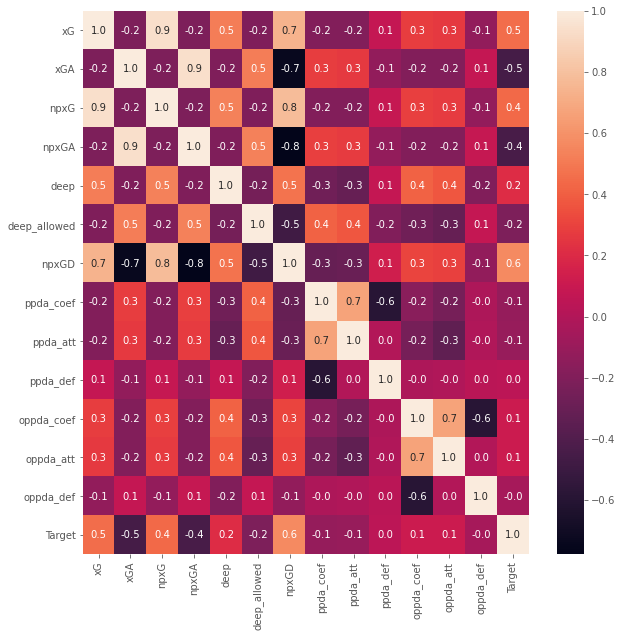

xGA            -0.457489
npxGA          -0.439251
deep_allowed   -0.214465
ppda_coef      -0.114393
ppda_att       -0.110976
oppda_def      -0.048139
ppda_def        0.048139
oppda_att       0.110976
oppda_coef      0.114393
deep            0.214465
npxG            0.439251
xG              0.457489
npxGD           0.564478
Target          1.000000
Name: Target, dtype: float64

In [11]:
# checking correlation
print(set(all_data))
plt.figure(figsize=(10,10))
sns.heatmap(all_data.corr(),annot=True,fmt='.1f')
plt.show()
corr_target=all_data[all_data.columns[0:]].corr()['Target'][:].sort_values(kind="quicksort") #except age
display(corr_target)

In [12]:
data = all_data.copy()

In [13]:
Target = data.pop('Target')
# normalize all the features to be from zer to one
for feat in data:
    data[feat] = NormalizingFromZeroToOne(data[feat])

In [14]:
print(set(data))

{'npxGD', 'oppda_att', 'npxGA', 'oppda_coef', 'npxG', 'deep', 'xG', 'xGA', 'ppda_def', 'oppda_def', 'deep_allowed', 'ppda_coef', 'ppda_att'}


<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Pre evaluation</font>

In [15]:
# split the data to train(70%), val(15%) and test(15%)
from sklearn.model_selection import train_test_split
x_train_val, x_test, y_train_val, y_test = train_test_split(data, Target, test_size=0.15, random_state=55)
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.20, random_state=55)
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
x_val = x_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [16]:
# convert the dataframes to np arrays 
x_train_arr = x_train.iloc[:,:].values
y_train_arr= y_train.iloc[:].values
x_val_arr = x_val.iloc[:,:].values
y_val_arr = y_val.iloc[:].values
x_test_arr = x_test.iloc[:,:].values
y_test_arr = y_test.iloc[:].values
# convert the targets to categorical 
y_train_arr = keras.utils.to_categorical(y_train_arr, 3)
y_val_arr = keras.utils.to_categorical(y_val_arr, 3)
y_test_arr = keras.utils.to_categorical(y_test_arr, 3)

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>First network model</font>

In [17]:
first_run_model, first_run_history = run_model(3,[16,16,16], [0,0,0], 'relu', 'Adagrad')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 5

In [18]:
prediction_matrix = first_run_model.predict(x=x_test, batch_size=32, verbose=2)
prediction_result = np.argmax(prediction_matrix, axis=-1)
first_run_error = get_error(y_test, prediction_result)
print('The error of the first model is: {}'.format(first_run_error))

3687/3687 - 0s
The error of the first model is: 1634.0


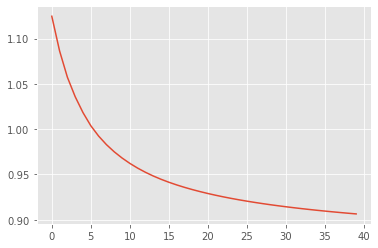

In [19]:
plt.plot(first_run_history.history['loss'])

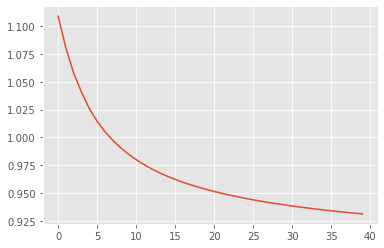

In [20]:
plt.plot(first_run_history.history['val_loss']) 

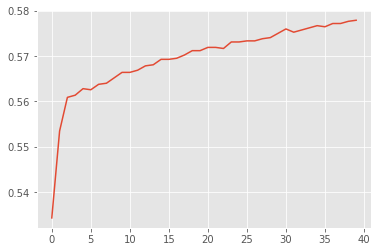

In [21]:
plt.plot(first_run_history.history['val_categorical_accuracy'])

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Sensitivity analysis on network parameters</font>

In [22]:
# number of neurons
loss_list = []
val_loss_list = []
val_loss_delta_list = []
val_accuracy_list = []
range_of_neurons = range(2, 80, 5)
for i in range_of_neurons:
    model, history = run_model(3,[i]*3, [0]*3, 'relu', 'Adagrad')
    loss_list.append(history.history['loss'][-1])
    val_loss_list.append(history.history['val_loss'][-1])
    val_loss_delta_list.append(history.history['val_loss'][0] - history.history['val_loss'][-1])
    val_accuracy_list.append(history.history['val_categorical_accuracy'][-1])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 28        
_________________________________________________________________
dropout_1 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 6         
_________________________________________________________________
dropout_2 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 6         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 9

Epoch 5/40
16714/16714 - 1s - loss: 1.0919 - categorical_accuracy: 0.5318 - val_loss: 1.0966 - val_categorical_accuracy: 0.5162
Epoch 6/40
16714/16714 - 1s - loss: 1.0883 - categorical_accuracy: 0.5357 - val_loss: 1.0935 - val_categorical_accuracy: 0.5190
Epoch 7/40
16714/16714 - 1s - loss: 1.0848 - categorical_accuracy: 0.5410 - val_loss: 1.0905 - val_categorical_accuracy: 0.5240
Epoch 8/40
16714/16714 - 1s - loss: 1.0814 - categorical_accuracy: 0.5458 - val_loss: 1.0875 - val_categorical_accuracy: 0.5274
Epoch 9/40
16714/16714 - 1s - loss: 1.0778 - categorical_accuracy: 0.5492 - val_loss: 1.0843 - val_categorical_accuracy: 0.5303
Epoch 10/40
16714/16714 - 1s - loss: 1.0742 - categorical_accuracy: 0.5528 - val_loss: 1.0811 - val_categorical_accuracy: 0.5353
Epoch 11/40
16714/16714 - 1s - loss: 1.0706 - categorical_accuracy: 0.5560 - val_loss: 1.0778 - val_categorical_accuracy: 0.5370
Epoch 12/40
16714/16714 - 1s - loss: 1.0669 - categorical_accuracy: 0.5590 - val_loss: 1.0745 - val_ca

Epoch 19/40
16714/16714 - 1s - loss: 0.9881 - categorical_accuracy: 0.5722 - val_loss: 1.0009 - val_categorical_accuracy: 0.5556
Epoch 20/40
16714/16714 - 1s - loss: 0.9839 - categorical_accuracy: 0.5728 - val_loss: 0.9971 - val_categorical_accuracy: 0.5561
Epoch 21/40
16714/16714 - 1s - loss: 0.9800 - categorical_accuracy: 0.5734 - val_loss: 0.9936 - val_categorical_accuracy: 0.5564
Epoch 22/40
16714/16714 - 1s - loss: 0.9762 - categorical_accuracy: 0.5743 - val_loss: 0.9903 - val_categorical_accuracy: 0.5573
Epoch 23/40
16714/16714 - 1s - loss: 0.9727 - categorical_accuracy: 0.5748 - val_loss: 0.9871 - val_categorical_accuracy: 0.5583
Epoch 24/40
16714/16714 - 1s - loss: 0.9694 - categorical_accuracy: 0.5754 - val_loss: 0.9841 - val_categorical_accuracy: 0.5592
Epoch 25/40
16714/16714 - 1s - loss: 0.9662 - categorical_accuracy: 0.5769 - val_loss: 0.9814 - val_categorical_accuracy: 0.5602
Epoch 26/40
16714/16714 - 1s - loss: 0.9633 - categorical_accuracy: 0.5769 - val_loss: 0.9787 - v

Epoch 33/40
16714/16714 - 1s - loss: 0.9217 - categorical_accuracy: 0.5966 - val_loss: 0.9464 - val_categorical_accuracy: 0.5760
Epoch 34/40
16714/16714 - 1s - loss: 0.9203 - categorical_accuracy: 0.5969 - val_loss: 0.9451 - val_categorical_accuracy: 0.5757
Epoch 35/40
16714/16714 - 1s - loss: 0.9189 - categorical_accuracy: 0.5971 - val_loss: 0.9440 - val_categorical_accuracy: 0.5765
Epoch 36/40
16714/16714 - 1s - loss: 0.9177 - categorical_accuracy: 0.5973 - val_loss: 0.9429 - val_categorical_accuracy: 0.5757
Epoch 37/40
16714/16714 - 1s - loss: 0.9165 - categorical_accuracy: 0.5976 - val_loss: 0.9418 - val_categorical_accuracy: 0.5757
Epoch 38/40
16714/16714 - 1s - loss: 0.9154 - categorical_accuracy: 0.5977 - val_loss: 0.9408 - val_categorical_accuracy: 0.5767
Epoch 39/40
16714/16714 - 1s - loss: 0.9143 - categorical_accuracy: 0.5981 - val_loss: 0.9399 - val_categorical_accuracy: 0.5769
Epoch 40/40
16714/16714 - 1s - loss: 0.9133 - categorical_accuracy: 0.5981 - val_loss: 0.9390 - v

16714/16714 - 1s - loss: 1.1425 - categorical_accuracy: 0.5376 - val_loss: 1.1239 - val_categorical_accuracy: 0.5449
Epoch 2/40
16714/16714 - 1s - loss: 1.0900 - categorical_accuracy: 0.5745 - val_loss: 1.0841 - val_categorical_accuracy: 0.5585
Epoch 3/40
16714/16714 - 1s - loss: 1.0499 - categorical_accuracy: 0.5809 - val_loss: 1.0529 - val_categorical_accuracy: 0.5628
Epoch 4/40
16714/16714 - 1s - loss: 1.0206 - categorical_accuracy: 0.5849 - val_loss: 1.0305 - val_categorical_accuracy: 0.5666
Epoch 5/40
16714/16714 - 1s - loss: 0.9998 - categorical_accuracy: 0.5878 - val_loss: 1.0146 - val_categorical_accuracy: 0.5693
Epoch 6/40
16714/16714 - 1s - loss: 0.9850 - categorical_accuracy: 0.5902 - val_loss: 1.0031 - val_categorical_accuracy: 0.5712
Epoch 7/40
16714/16714 - 1s - loss: 0.9741 - categorical_accuracy: 0.5915 - val_loss: 0.9944 - val_categorical_accuracy: 0.5714
Epoch 8/40
16714/16714 - 1s - loss: 0.9658 - categorical_accuracy: 0.5929 - val_loss: 0.9876 - val_categorical_accu

Epoch 15/40
16714/16714 - 1s - loss: 0.9405 - categorical_accuracy: 0.6002 - val_loss: 0.9645 - val_categorical_accuracy: 0.5748
Epoch 16/40
16714/16714 - 1s - loss: 0.9374 - categorical_accuracy: 0.6014 - val_loss: 0.9619 - val_categorical_accuracy: 0.5765
Epoch 17/40
16714/16714 - 1s - loss: 0.9347 - categorical_accuracy: 0.6021 - val_loss: 0.9595 - val_categorical_accuracy: 0.5769
Epoch 18/40
16714/16714 - 1s - loss: 0.9323 - categorical_accuracy: 0.6022 - val_loss: 0.9573 - val_categorical_accuracy: 0.5779
Epoch 19/40
16714/16714 - 1s - loss: 0.9302 - categorical_accuracy: 0.6022 - val_loss: 0.9554 - val_categorical_accuracy: 0.5781
Epoch 20/40
16714/16714 - 1s - loss: 0.9283 - categorical_accuracy: 0.6028 - val_loss: 0.9537 - val_categorical_accuracy: 0.5784
Epoch 21/40
16714/16714 - 1s - loss: 0.9265 - categorical_accuracy: 0.6033 - val_loss: 0.9521 - val_categorical_accuracy: 0.5791
Epoch 22/40
16714/16714 - 1s - loss: 0.9249 - categorical_accuracy: 0.6035 - val_loss: 0.9506 - v

Epoch 29/40
16714/16714 - 1s - loss: 0.9201 - categorical_accuracy: 0.6072 - val_loss: 0.9469 - val_categorical_accuracy: 0.5858
Epoch 30/40
16714/16714 - 1s - loss: 0.9195 - categorical_accuracy: 0.6078 - val_loss: 0.9463 - val_categorical_accuracy: 0.5863
Epoch 31/40
16714/16714 - 1s - loss: 0.9189 - categorical_accuracy: 0.6079 - val_loss: 0.9457 - val_categorical_accuracy: 0.5858
Epoch 32/40
16714/16714 - 1s - loss: 0.9184 - categorical_accuracy: 0.6079 - val_loss: 0.9452 - val_categorical_accuracy: 0.5855
Epoch 33/40
16714/16714 - 1s - loss: 0.9179 - categorical_accuracy: 0.6082 - val_loss: 0.9447 - val_categorical_accuracy: 0.5855
Epoch 34/40
16714/16714 - 1s - loss: 0.9174 - categorical_accuracy: 0.6082 - val_loss: 0.9442 - val_categorical_accuracy: 0.5848
Epoch 35/40
16714/16714 - 1s - loss: 0.9170 - categorical_accuracy: 0.6083 - val_loss: 0.9437 - val_categorical_accuracy: 0.5855
Epoch 36/40
16714/16714 - 1s - loss: 0.9165 - categorical_accuracy: 0.6087 - val_loss: 0.9433 - v

Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 1s - loss: 1.1848 - categorical_accuracy: 0.5680 - val_loss: 1.1477 - val_categorical_accuracy: 0.5568
Epoch 2/40
16714/16714 - 1s - loss: 1.0974 - categorical_accuracy: 0.5903 - val_loss: 1.0856 - val_categorical_accuracy: 0.5597
Epoch 3/40
16714/16714 - 1s - loss: 1.0460 - categorical_accuracy: 0.5927 - val_loss: 1.0510 - val_categorical_accuracy: 0.5650
Epoch 4/40
16714/16714 - 1s - loss: 1.0175 - categorical_accuracy: 0.5932 - val_loss: 1.0310 - val_categorical_accuracy: 0.5678
Epoch 5/40
16714/16714 - 1s - loss: 1.0003 - categorical_accuracy: 0.5945 - val_loss: 1.0180 - val_categorical_accuracy: 0.5702
Epoch 6/40
16714/16714 - 1s - loss: 0.9887 - categorical_accuracy: 0.5958 - val_loss: 1.0086 - val_categorical_accuracy: 0.5733
Epoch 7/40
16714/16714 - 1s - loss: 0.9802 - categorical_accuracy: 0.5967 - val_loss: 1.0015 - val_categorical_accuracy: 0.5738
Epoch 8/40
16714/16714 - 1s - loss: 0.9735 - categorica

Epoch 14/40
16714/16714 - 1s - loss: 0.9601 - categorical_accuracy: 0.6008 - val_loss: 0.9850 - val_categorical_accuracy: 0.5769
Epoch 15/40
16714/16714 - 1s - loss: 0.9574 - categorical_accuracy: 0.6013 - val_loss: 0.9825 - val_categorical_accuracy: 0.5788
Epoch 16/40
16714/16714 - 1s - loss: 0.9550 - categorical_accuracy: 0.6014 - val_loss: 0.9803 - val_categorical_accuracy: 0.5810
Epoch 17/40
16714/16714 - 1s - loss: 0.9529 - categorical_accuracy: 0.6017 - val_loss: 0.9782 - val_categorical_accuracy: 0.5805
Epoch 18/40
16714/16714 - 1s - loss: 0.9509 - categorical_accuracy: 0.6021 - val_loss: 0.9763 - val_categorical_accuracy: 0.5808
Epoch 19/40
16714/16714 - 1s - loss: 0.9491 - categorical_accuracy: 0.6027 - val_loss: 0.9746 - val_categorical_accuracy: 0.5822
Epoch 20/40
16714/16714 - 1s - loss: 0.9475 - categorical_accuracy: 0.6029 - val_loss: 0.9730 - val_categorical_accuracy: 0.5822
Epoch 21/40
16714/16714 - 1s - loss: 0.9460 - categorical_accuracy: 0.6028 - val_loss: 0.9716 - v

Epoch 28/40
16714/16714 - 1s - loss: 0.9423 - categorical_accuracy: 0.6086 - val_loss: 0.9689 - val_categorical_accuracy: 0.5853
Epoch 29/40
16714/16714 - 1s - loss: 0.9416 - categorical_accuracy: 0.6088 - val_loss: 0.9682 - val_categorical_accuracy: 0.5853
Epoch 30/40
16714/16714 - 1s - loss: 0.9409 - categorical_accuracy: 0.6091 - val_loss: 0.9675 - val_categorical_accuracy: 0.5855
Epoch 31/40
16714/16714 - 1s - loss: 0.9402 - categorical_accuracy: 0.6091 - val_loss: 0.9669 - val_categorical_accuracy: 0.5863
Epoch 32/40
16714/16714 - 1s - loss: 0.9396 - categorical_accuracy: 0.6093 - val_loss: 0.9663 - val_categorical_accuracy: 0.5863
Epoch 33/40
16714/16714 - 1s - loss: 0.9390 - categorical_accuracy: 0.6094 - val_loss: 0.9657 - val_categorical_accuracy: 0.5867
Epoch 34/40
16714/16714 - 1s - loss: 0.9385 - categorical_accuracy: 0.6098 - val_loss: 0.9651 - val_categorical_accuracy: 0.5877
Epoch 35/40
16714/16714 - 1s - loss: 0.9379 - categorical_accuracy: 0.6100 - val_loss: 0.9646 - v

16714/16714 - 1s - loss: 1.1908 - categorical_accuracy: 0.5758 - val_loss: 1.1328 - val_categorical_accuracy: 0.5616
Epoch 2/40
16714/16714 - 1s - loss: 1.0836 - categorical_accuracy: 0.5912 - val_loss: 1.0865 - val_categorical_accuracy: 0.5678
Epoch 3/40
16714/16714 - 1s - loss: 1.0504 - categorical_accuracy: 0.5944 - val_loss: 1.0648 - val_categorical_accuracy: 0.5717
Epoch 4/40
16714/16714 - 1s - loss: 1.0324 - categorical_accuracy: 0.5966 - val_loss: 1.0508 - val_categorical_accuracy: 0.5753
Epoch 5/40
16714/16714 - 1s - loss: 1.0202 - categorical_accuracy: 0.5982 - val_loss: 1.0406 - val_categorical_accuracy: 0.5762
Epoch 6/40
16714/16714 - 1s - loss: 1.0109 - categorical_accuracy: 0.5997 - val_loss: 1.0325 - val_categorical_accuracy: 0.5788
Epoch 7/40
16714/16714 - 1s - loss: 1.0036 - categorical_accuracy: 0.6012 - val_loss: 1.0260 - val_categorical_accuracy: 0.5800
Epoch 8/40
16714/16714 - 1s - loss: 0.9976 - categorical_accuracy: 0.6014 - val_loss: 1.0206 - val_categorical_accu

Epoch 15/40
16714/16714 - 1s - loss: 0.9649 - categorical_accuracy: 0.6069 - val_loss: 0.9912 - val_categorical_accuracy: 0.5865
Epoch 16/40
16714/16714 - 1s - loss: 0.9628 - categorical_accuracy: 0.6075 - val_loss: 0.9891 - val_categorical_accuracy: 0.5867
Epoch 17/40
16714/16714 - 1s - loss: 0.9609 - categorical_accuracy: 0.6081 - val_loss: 0.9873 - val_categorical_accuracy: 0.5877
Epoch 18/40
16714/16714 - 1s - loss: 0.9592 - categorical_accuracy: 0.6083 - val_loss: 0.9856 - val_categorical_accuracy: 0.5872
Epoch 19/40
16714/16714 - 1s - loss: 0.9576 - categorical_accuracy: 0.6081 - val_loss: 0.9841 - val_categorical_accuracy: 0.5879
Epoch 20/40
16714/16714 - 1s - loss: 0.9562 - categorical_accuracy: 0.6076 - val_loss: 0.9827 - val_categorical_accuracy: 0.5882
Epoch 21/40
16714/16714 - 1s - loss: 0.9549 - categorical_accuracy: 0.6082 - val_loss: 0.9815 - val_categorical_accuracy: 0.5884
Epoch 22/40
16714/16714 - 1s - loss: 0.9537 - categorical_accuracy: 0.6082 - val_loss: 0.9803 - v

Epoch 29/40
16714/16714 - 1s - loss: 0.9479 - categorical_accuracy: 0.6085 - val_loss: 0.9728 - val_categorical_accuracy: 0.5867
Epoch 30/40
16714/16714 - 1s - loss: 0.9472 - categorical_accuracy: 0.6085 - val_loss: 0.9721 - val_categorical_accuracy: 0.5872
Epoch 31/40
16714/16714 - 1s - loss: 0.9465 - categorical_accuracy: 0.6088 - val_loss: 0.9714 - val_categorical_accuracy: 0.5879
Epoch 32/40
16714/16714 - 1s - loss: 0.9459 - categorical_accuracy: 0.6087 - val_loss: 0.9708 - val_categorical_accuracy: 0.5879
Epoch 33/40
16714/16714 - 1s - loss: 0.9453 - categorical_accuracy: 0.6089 - val_loss: 0.9703 - val_categorical_accuracy: 0.5877
Epoch 34/40
16714/16714 - 1s - loss: 0.9448 - categorical_accuracy: 0.6091 - val_loss: 0.9697 - val_categorical_accuracy: 0.5879
Epoch 35/40
16714/16714 - 1s - loss: 0.9442 - categorical_accuracy: 0.6091 - val_loss: 0.9692 - val_categorical_accuracy: 0.5882
Epoch 36/40
16714/16714 - 1s - loss: 0.9437 - categorical_accuracy: 0.6092 - val_loss: 0.9687 - v

Text(0, 0.5, 'val accuracy')

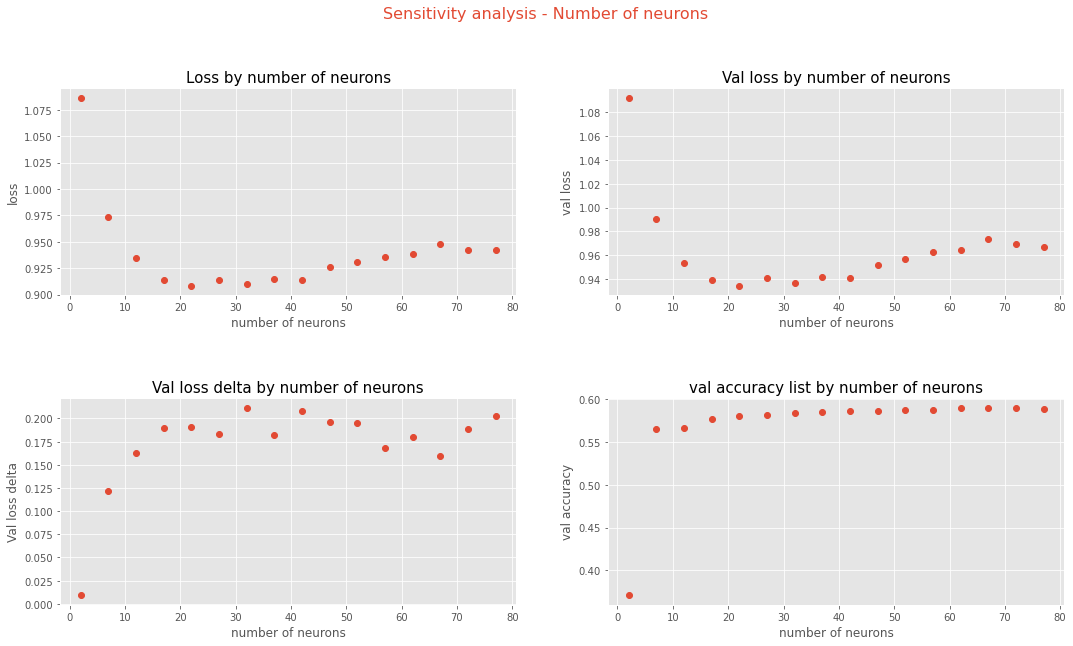

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(18, 9.5))
fig.suptitle('Sensitivity analysis - Number of neurons', y=1 , color='C0', size='16')
fig.subplots_adjust(hspace=0.5)
axs[0][0].plot(range_of_neurons, loss_list, 'o')
axs[0][0].set_title('Loss by number of neurons', fontsize=15)
axs[0][0].set_xlabel('number of neurons')
axs[0][0].set_ylabel('loss')

axs[0][1].plot(range_of_neurons, val_loss_list, 'o')
axs[0][1].set_title('Val loss by number of neurons', fontsize=15)
axs[0][1].set_xlabel('number of neurons')
axs[0][1].set_ylabel('val loss')

axs[1][0].plot(range_of_neurons, val_loss_delta_list, 'o')
axs[1][0].set_title('Val loss delta by number of neurons', fontsize=15)
axs[1][0].set_xlabel('number of neurons')
axs[1][0].set_ylabel('Val loss delta')

axs[1][1].plot(range_of_neurons, val_accuracy_list, 'o')
axs[1][1].set_title('val accuracy list by number of neurons', fontsize=15)
axs[1][1].set_xlabel('number of neurons')
axs[1][1].set_ylabel('val accuracy')

In [24]:
# number of layers
loss_list = []
val_loss_list = []
val_loss_delta_list = []
val_accuracy_list = []
range_of_layers = range(1, 20)
for i in range_of_layers:
    model, history = run_model(i,[16]*i, [0]*i, 'relu', 'Adagrad')
    loss_list.append(history.history['loss'][-1])
    val_loss_list.append(history.history['val_loss'][-1])
    val_loss_delta_list.append(history.history['val_loss'][0] - history.history['val_loss'][-1])
    val_accuracy_list.append(history.history['val_categorical_accuracy'][-1])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 51        
Total params: 275
Trainable params: 275
Non-trainable params: 0
_________________________________________________________________
Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 1s - loss: 1.1491 - categorical_accuracy: 0.3748 - val_loss: 1.1296 - val_categorical_accuracy: 0.3623
Epoch 2/40
16714/16714 - 1s - loss: 1.1167 - categorical_accuracy: 0.3742 - val_loss: 1.1098 - val_categorical_accuracy: 0.3613
Epoch 3/40
16714/16714 - 1s - loss: 1.0986 - categorical_accuracy: 0.3923 - val_los

Epoch 11/40
16714/16714 - 1s - loss: 0.9777 - categorical_accuracy: 0.5773 - val_loss: 0.9882 - val_categorical_accuracy: 0.5604
Epoch 12/40
16714/16714 - 1s - loss: 0.9707 - categorical_accuracy: 0.5790 - val_loss: 0.9820 - val_categorical_accuracy: 0.5628
Epoch 13/40
16714/16714 - 1s - loss: 0.9644 - categorical_accuracy: 0.5812 - val_loss: 0.9768 - val_categorical_accuracy: 0.5628
Epoch 14/40
16714/16714 - 1s - loss: 0.9589 - categorical_accuracy: 0.5818 - val_loss: 0.9722 - val_categorical_accuracy: 0.5640
Epoch 15/40
16714/16714 - 1s - loss: 0.9540 - categorical_accuracy: 0.5829 - val_loss: 0.9680 - val_categorical_accuracy: 0.5635
Epoch 16/40
16714/16714 - 1s - loss: 0.9495 - categorical_accuracy: 0.5841 - val_loss: 0.9642 - val_categorical_accuracy: 0.5647
Epoch 17/40
16714/16714 - 1s - loss: 0.9454 - categorical_accuracy: 0.5851 - val_loss: 0.9607 - val_categorical_accuracy: 0.5669
Epoch 18/40
16714/16714 - 1s - loss: 0.9418 - categorical_accuracy: 0.5861 - val_loss: 0.9576 - v

Epoch 25/40
16714/16714 - 1s - loss: 0.9078 - categorical_accuracy: 0.5996 - val_loss: 0.9328 - val_categorical_accuracy: 0.5815
Epoch 26/40
16714/16714 - 1s - loss: 0.9068 - categorical_accuracy: 0.6002 - val_loss: 0.9318 - val_categorical_accuracy: 0.5815
Epoch 27/40
16714/16714 - 1s - loss: 0.9058 - categorical_accuracy: 0.6006 - val_loss: 0.9309 - val_categorical_accuracy: 0.5817
Epoch 28/40
16714/16714 - 1s - loss: 0.9049 - categorical_accuracy: 0.6006 - val_loss: 0.9301 - val_categorical_accuracy: 0.5829
Epoch 29/40
16714/16714 - 1s - loss: 0.9040 - categorical_accuracy: 0.6011 - val_loss: 0.9293 - val_categorical_accuracy: 0.5832
Epoch 30/40
16714/16714 - 1s - loss: 0.9033 - categorical_accuracy: 0.6013 - val_loss: 0.9285 - val_categorical_accuracy: 0.5834
Epoch 31/40
16714/16714 - 1s - loss: 0.9025 - categorical_accuracy: 0.6014 - val_loss: 0.9278 - val_categorical_accuracy: 0.5836
Epoch 32/40
16714/16714 - 1s - loss: 0.9018 - categorical_accuracy: 0.6013 - val_loss: 0.9271 - v

Epoch 37/40
16714/16714 - 1s - loss: 0.9183 - categorical_accuracy: 0.6000 - val_loss: 0.9454 - val_categorical_accuracy: 0.5733
Epoch 38/40
16714/16714 - 1s - loss: 0.9175 - categorical_accuracy: 0.6000 - val_loss: 0.9447 - val_categorical_accuracy: 0.5731
Epoch 39/40
16714/16714 - 1s - loss: 0.9168 - categorical_accuracy: 0.6003 - val_loss: 0.9440 - val_categorical_accuracy: 0.5724
Epoch 40/40
16714/16714 - 1s - loss: 0.9161 - categorical_accuracy: 0.6004 - val_loss: 0.9434 - val_categorical_accuracy: 0.5724
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
__

Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 1s - loss: 1.1942 - categorical_accuracy: 0.5501 - val_loss: 1.1732 - val_categorical_accuracy: 0.5652
Epoch 2/40
16714/16714 - 1s - loss: 1.1443 - categorical_accuracy: 0.5838 - val_loss: 1.1277 - val_categorical_accuracy: 0.5686
Epoch 3/40
16714/16714 - 1s - loss: 1.0946 - categorical_accuracy: 0.5919 - val_loss: 1.0848 - val_categorical_accuracy: 0.5743
Epoch 4/40
16714/16714 - 1s - loss: 1.0508 - categorical_accuracy: 0.5957 - val_loss: 1.0505 - val_categorical_accuracy: 0.5769
Epoch 5/40
16714/16714 - 1s - loss: 1.0180 - categorical_accuracy: 0.5966 - val_loss: 1.0269 - val_categorical_accuracy: 0.5765
Epoch 6/40
16714/16714 - 1s - loss: 0.9957 - categorical_accuracy: 0.5984 - val_loss: 1.0112 - val_categorical_accuracy: 0.5767
Epoch 7/40
16714/16714 - 1s - loss: 0.9807 - categorical_accuracy: 0.6006 - val_loss: 1.0004 - val_categorical_accuracy: 0.5762
Epoch 8/40
16714/16714 - 1s - loss: 0.9702 - categorica

Epoch 6/40
16714/16714 - 1s - loss: 1.0592 - categorical_accuracy: 0.5847 - val_loss: 1.0611 - val_categorical_accuracy: 0.5599
Epoch 7/40
16714/16714 - 1s - loss: 1.0333 - categorical_accuracy: 0.5900 - val_loss: 1.0411 - val_categorical_accuracy: 0.5628
Epoch 8/40
16714/16714 - 1s - loss: 1.0131 - categorical_accuracy: 0.5927 - val_loss: 1.0257 - val_categorical_accuracy: 0.5666
Epoch 9/40
16714/16714 - 1s - loss: 0.9979 - categorical_accuracy: 0.5945 - val_loss: 1.0143 - val_categorical_accuracy: 0.5681
Epoch 10/40
16714/16714 - 1s - loss: 0.9864 - categorical_accuracy: 0.5947 - val_loss: 1.0056 - val_categorical_accuracy: 0.5686
Epoch 11/40
16714/16714 - 1s - loss: 0.9775 - categorical_accuracy: 0.5960 - val_loss: 0.9983 - val_categorical_accuracy: 0.5698
Epoch 12/40
16714/16714 - 1s - loss: 0.9702 - categorical_accuracy: 0.5976 - val_loss: 0.9923 - val_categorical_accuracy: 0.5717
Epoch 13/40
16714/16714 - 1s - loss: 0.9643 - categorical_accuracy: 0.5992 - val_loss: 0.9875 - val_c

Epoch 10/40
16714/16714 - 1s - loss: 1.0303 - categorical_accuracy: 0.6045 - val_loss: 1.0492 - val_categorical_accuracy: 0.5760
Epoch 11/40
16714/16714 - 1s - loss: 1.0247 - categorical_accuracy: 0.6049 - val_loss: 1.0440 - val_categorical_accuracy: 0.5767
Epoch 12/40
16714/16714 - 1s - loss: 1.0196 - categorical_accuracy: 0.6047 - val_loss: 1.0393 - val_categorical_accuracy: 0.5772
Epoch 13/40
16714/16714 - 1s - loss: 1.0149 - categorical_accuracy: 0.6046 - val_loss: 1.0349 - val_categorical_accuracy: 0.5781
Epoch 14/40
16714/16714 - 1s - loss: 1.0105 - categorical_accuracy: 0.6049 - val_loss: 1.0307 - val_categorical_accuracy: 0.5791
Epoch 15/40
16714/16714 - 1s - loss: 1.0064 - categorical_accuracy: 0.6051 - val_loss: 1.0269 - val_categorical_accuracy: 0.5791
Epoch 16/40
16714/16714 - 1s - loss: 1.0026 - categorical_accuracy: 0.6055 - val_loss: 1.0233 - val_categorical_accuracy: 0.5796
Epoch 17/40
16714/16714 - 1s - loss: 0.9990 - categorical_accuracy: 0.6056 - val_loss: 1.0199 - v

16714/16714 - 1s - loss: 0.9875 - categorical_accuracy: 0.6018 - val_loss: 1.0113 - val_categorical_accuracy: 0.5820
Epoch 12/40
16714/16714 - 1s - loss: 0.9836 - categorical_accuracy: 0.6021 - val_loss: 1.0076 - val_categorical_accuracy: 0.5820
Epoch 13/40
16714/16714 - 1s - loss: 0.9802 - categorical_accuracy: 0.6027 - val_loss: 1.0044 - val_categorical_accuracy: 0.5829
Epoch 14/40
16714/16714 - 1s - loss: 0.9772 - categorical_accuracy: 0.6028 - val_loss: 1.0015 - val_categorical_accuracy: 0.5844
Epoch 15/40
16714/16714 - 1s - loss: 0.9745 - categorical_accuracy: 0.6028 - val_loss: 0.9989 - val_categorical_accuracy: 0.5848
Epoch 16/40
16714/16714 - 1s - loss: 0.9721 - categorical_accuracy: 0.6033 - val_loss: 0.9965 - val_categorical_accuracy: 0.5851
Epoch 17/40
16714/16714 - 1s - loss: 0.9700 - categorical_accuracy: 0.6039 - val_loss: 0.9944 - val_categorical_accuracy: 0.5853
Epoch 18/40
16714/16714 - 1s - loss: 0.9679 - categorical_accuracy: 0.6045 - val_loss: 0.9924 - val_categoric

16714/16714 - 1s - loss: 1.1001 - categorical_accuracy: 0.5815 - val_loss: 1.1065 - val_categorical_accuracy: 0.5592
Epoch 11/40
16714/16714 - 1s - loss: 1.0874 - categorical_accuracy: 0.5871 - val_loss: 1.0960 - val_categorical_accuracy: 0.5635
Epoch 12/40
16714/16714 - 1s - loss: 1.0770 - categorical_accuracy: 0.5907 - val_loss: 1.0871 - val_categorical_accuracy: 0.5664
Epoch 13/40
16714/16714 - 1s - loss: 1.0681 - categorical_accuracy: 0.5928 - val_loss: 1.0791 - val_categorical_accuracy: 0.5678
Epoch 14/40
16714/16714 - 1s - loss: 1.0601 - categorical_accuracy: 0.5938 - val_loss: 1.0720 - val_categorical_accuracy: 0.5693
Epoch 15/40
16714/16714 - 1s - loss: 1.0527 - categorical_accuracy: 0.5951 - val_loss: 1.0651 - val_categorical_accuracy: 0.5714
Epoch 16/40
16714/16714 - 1s - loss: 1.0459 - categorical_accuracy: 0.5961 - val_loss: 1.0590 - val_categorical_accuracy: 0.5717
Epoch 17/40
16714/16714 - 1s - loss: 1.0399 - categorical_accuracy: 0.5978 - val_loss: 1.0536 - val_categoric

16714/16714 - 1s - loss: 1.1012 - categorical_accuracy: 0.5909 - val_loss: 1.1041 - val_categorical_accuracy: 0.5719
Epoch 8/40
16714/16714 - 1s - loss: 1.0704 - categorical_accuracy: 0.5942 - val_loss: 1.0795 - val_categorical_accuracy: 0.5721
Epoch 9/40
16714/16714 - 1s - loss: 1.0464 - categorical_accuracy: 0.5958 - val_loss: 1.0605 - val_categorical_accuracy: 0.5731
Epoch 10/40
16714/16714 - 1s - loss: 1.0284 - categorical_accuracy: 0.5979 - val_loss: 1.0462 - val_categorical_accuracy: 0.5750
Epoch 11/40
16714/16714 - 1s - loss: 1.0146 - categorical_accuracy: 0.5981 - val_loss: 1.0346 - val_categorical_accuracy: 0.5784
Epoch 12/40
16714/16714 - 1s - loss: 1.0040 - categorical_accuracy: 0.5998 - val_loss: 1.0253 - val_categorical_accuracy: 0.5793
Epoch 13/40
16714/16714 - 1s - loss: 0.9956 - categorical_accuracy: 0.6006 - val_loss: 1.0180 - val_categorical_accuracy: 0.5793
Epoch 14/40
16714/16714 - 1s - loss: 0.9888 - categorical_accuracy: 0.6012 - val_loss: 1.0118 - val_categorical

Epoch 2/40
16714/16714 - 1s - loss: 1.2194 - categorical_accuracy: 0.5586 - val_loss: 1.1922 - val_categorical_accuracy: 0.5430
Epoch 3/40
16714/16714 - 1s - loss: 1.1596 - categorical_accuracy: 0.5879 - val_loss: 1.1514 - val_categorical_accuracy: 0.5659
Epoch 4/40
16714/16714 - 1s - loss: 1.1256 - categorical_accuracy: 0.5974 - val_loss: 1.1258 - val_categorical_accuracy: 0.5777
Epoch 5/40
16714/16714 - 1s - loss: 1.1012 - categorical_accuracy: 0.5998 - val_loss: 1.1062 - val_categorical_accuracy: 0.5798
Epoch 6/40
16714/16714 - 1s - loss: 1.0810 - categorical_accuracy: 0.6006 - val_loss: 1.0899 - val_categorical_accuracy: 0.5812
Epoch 7/40
16714/16714 - 1s - loss: 1.0641 - categorical_accuracy: 0.6028 - val_loss: 1.0765 - val_categorical_accuracy: 0.5827
Epoch 8/40
16714/16714 - 1s - loss: 1.0504 - categorical_accuracy: 0.6037 - val_loss: 1.0659 - val_categorical_accuracy: 0.5839
Epoch 9/40
16714/16714 - 1s - loss: 1.0395 - categorical_accuracy: 0.6042 - val_loss: 1.0575 - val_categ

Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 2s - loss: 1.3190 - categorical_accuracy: 0.4626 - val_loss: 1.2971 - val_categorical_accuracy: 0.5430
Epoch 2/40
16714/16714 - 1s - loss: 1.2799 - categorical_accuracy: 0.5118 - val_loss: 1.2722 - val_categorical_accuracy: 0.5568
Epoch 3/40
16714/16714 - 1s - loss: 1.2588 - categorical_accuracy: 0.4787 - val_loss: 1.2557 - val_categorical_accuracy: 0.5286
Epoch 4/40
16714/16714 - 1s - loss: 1.2438 - categorical_accuracy: 0.4600 - val_loss: 1.2433 - val_categorical_accuracy: 0.5049
Epoch 5/40
16714/16714 - 1s - loss: 1.2322 - categorical_accuracy: 0.4566 - val_loss: 1.2331 - val_categorical_accuracy: 0.4980
Epoch 6/40
16714/16714 - 1s - loss: 1.2225 - categorical_accuracy: 0.4624 - val_loss: 1.2245 - val_categorical_accuracy: 0.4905
Epoch 7/40
16714/16714 - 1s - loss: 1.2142 - categorical_accuracy: 0.4710 - val_loss: 1.2170 - val_categorical_accuracy: 0.4886
Epoch 8/40
16714/16714 - 1s - loss: 1.2068 - categorica

Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 2s - loss: 1.3411 - categorical_accuracy: 0.3747 - val_loss: 1.3189 - val_categorical_accuracy: 0.3620
Epoch 2/40
16714/16714 - 1s - loss: 1.2998 - categorical_accuracy: 0.3746 - val_loss: 1.2931 - val_categorical_accuracy: 0.3620
Epoch 3/40
16714/16714 - 1s - loss: 1.2778 - categorical_accuracy: 0.3746 - val_loss: 1.2753 - val_categorical_accuracy: 0.3620
Epoch 4/40
16714/16714 - 1s - loss: 1.2618 - categorical_accuracy: 0.3746 - val_loss: 1.2614 - val_categorical_accuracy: 0.3620
Epoch 5/40
16714/16714 - 1s - loss: 1.2490 - categorical_accuracy: 0.3746 - val_loss: 1.2500 - val_categorical_accuracy: 0.3620
Epoch 6/40
16714/16714 - 1s - loss: 1.2383 - categorical_accuracy: 0.3746 - val_loss: 1.2402 - val_categorical_accuracy: 0.3620
Epoch 7/40
16714/16714 - 1s - loss: 1.2291 - categorical_accuracy: 0.3746 - val_loss: 1.2316 - val_categorical_accuracy: 0.3620
Epoch 8/40
16714/16714 - 1s - loss: 1.2210 - categorica

Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 3s - loss: 1.3616 - categorical_accuracy: 0.3744 - val_loss: 1.3357 - val_categorical_accuracy: 0.3620
Epoch 2/40
16714/16714 - 1s - loss: 1.3165 - categorical_accuracy: 0.3746 - val_loss: 1.3060 - val_categorical_accuracy: 0.3620
Epoch 3/40
16714/16714 - 1s - loss: 1.2913 - categorical_accuracy: 0.3746 - val_loss: 1.2855 - val_categorical_accuracy: 0.3620
Epoch 4/40
16714/16714 - 1s - loss: 1.2728 - categorical_accuracy: 0.3746 - val_loss: 1.2697 - val_categorical_accuracy: 0.3620
Epoch 5/40
16714/16714 - 1s - loss: 1.2581 - categorical_accuracy: 0.3746 - val_loss: 1.2568 - val_categorical_accuracy: 0.3620
Epoch 6/40
16714/16714 - 1s - loss: 1.2459 - categorical_accuracy: 0.3746 - val_loss: 1.2458 - val_categorical_accuracy: 0.3620
Epoch 7/40
16714/16714 - 1s - loss: 1.2354 - categorical_accuracy: 0.3746 - val_loss: 1.2363 - val_categorical_accuracy: 0.3620
Epoch 8/40
16714/16714 - 1s - loss: 1.2262 - categorica

Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 2s - loss: 1.3731 - categorical_accuracy: 0.3733 - val_loss: 1.3476 - val_categorical_accuracy: 0.3620
Epoch 2/40
16714/16714 - 1s - loss: 1.3265 - categorical_accuracy: 0.3752 - val_loss: 1.3185 - val_categorical_accuracy: 0.3620
Epoch 3/40
16714/16714 - 1s - loss: 1.3018 - categorical_accuracy: 0.3753 - val_loss: 1.2984 - val_categorical_accuracy: 0.3625
Epoch 4/40
16714/16714 - 1s - loss: 1.2837 - categorical_accuracy: 0.3759 - val_loss: 1.2825 - val_categorical_accuracy: 0.3668
Epoch 5/40
16714/16714 - 1s - loss: 1.2692 - categorical_accuracy: 0.3753 - val_loss: 1.2694 - val_categorical_accuracy: 0.4606
Epoch 6/40
16714/16714 - 1s - loss: 1.2570 - categorical_accuracy: 0.3743 - val_loss: 1.2582 - val_categorical_accuracy: 0.3707
Epoch 7/40
16714/16714 - 1s - loss: 1.2464 - categorical_accuracy: 0.3747 - val_loss: 1.2484 - val_categorical_accuracy: 0.3707
Epoch 8/40
16714/16714 - 1s - loss: 1.2372 - categorica

Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 3s - loss: 1.3826 - categorical_accuracy: 0.3754 - val_loss: 1.3547 - val_categorical_accuracy: 0.3707
Epoch 2/40
16714/16714 - 1s - loss: 1.3332 - categorical_accuracy: 0.3757 - val_loss: 1.3233 - val_categorical_accuracy: 0.3707
Epoch 3/40
16714/16714 - 1s - loss: 1.3067 - categorical_accuracy: 0.3757 - val_loss: 1.3019 - val_categorical_accuracy: 0.3707
Epoch 4/40
16714/16714 - 1s - loss: 1.2874 - categorical_accuracy: 0.3757 - val_loss: 1.2853 - val_categorical_accuracy: 0.3707
Epoch 5/40
16714/16714 - 1s - loss: 1.2721 - categorical_accuracy: 0.3757 - val_loss: 1.2716 - val_categorical_accuracy: 0.3707
Epoch 6/40
16714/16714 - 1s - loss: 1.2593 - categorical_accuracy: 0.3757 - val_loss: 1.2599 - val_categorical_accuracy: 0.3707
Epoch 7/40
16714/16714 - 1s - loss: 1.2483 - categorical_accuracy: 0.3757 - val_loss: 1.2498 - val_categorical_accuracy: 0.3707
Epoch 8/40
16714/16714 - 1s - loss: 1.2386 - categorica

Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 3s - loss: 1.4156 - categorical_accuracy: 0.3754 - val_loss: 1.3843 - val_categorical_accuracy: 0.3707
Epoch 2/40
16714/16714 - 1s - loss: 1.3620 - categorical_accuracy: 0.3757 - val_loss: 1.3493 - val_categorical_accuracy: 0.3707
Epoch 3/40
16714/16714 - 1s - loss: 1.3324 - categorical_accuracy: 0.3757 - val_loss: 1.3255 - val_categorical_accuracy: 0.3707
Epoch 4/40
16714/16714 - 1s - loss: 1.3109 - categorical_accuracy: 0.3757 - val_loss: 1.3072 - val_categorical_accuracy: 0.3707
Epoch 5/40
16714/16714 - 1s - loss: 1.2939 - categorical_accuracy: 0.3757 - val_loss: 1.2921 - val_categorical_accuracy: 0.3707
Epoch 6/40
16714/16714 - 1s - loss: 1.2797 - categorical_accuracy: 0.3757 - val_loss: 1.2793 - val_categorical_accuracy: 0.3707
Epoch 7/40
16714/16714 - 1s - loss: 1.2676 - categorical_accuracy: 0.3757 - val_loss: 1.2682 - val_categorical_accuracy: 0.3707
Epoch 8/40
16714/16714 - 1s - loss: 1.2570 - categorica

Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 3s - loss: 1.4241 - categorical_accuracy: 0.3746 - val_loss: 1.3926 - val_categorical_accuracy: 0.3620
Epoch 2/40
16714/16714 - 1s - loss: 1.3689 - categorical_accuracy: 0.3746 - val_loss: 1.3570 - val_categorical_accuracy: 0.3620
Epoch 3/40
16714/16714 - 1s - loss: 1.3388 - categorical_accuracy: 0.3746 - val_loss: 1.3327 - val_categorical_accuracy: 0.3620
Epoch 4/40
16714/16714 - 1s - loss: 1.3170 - categorical_accuracy: 0.3746 - val_loss: 1.3139 - val_categorical_accuracy: 0.3620
Epoch 5/40
16714/16714 - 1s - loss: 1.2996 - categorical_accuracy: 0.3746 - val_loss: 1.2983 - val_categorical_accuracy: 0.3620
Epoch 6/40
16714/16714 - 1s - loss: 1.2851 - categorical_accuracy: 0.3746 - val_loss: 1.2850 - val_categorical_accuracy: 0.3620
Epoch 7/40
16714/16714 - 1s - loss: 1.2726 - categorical_accuracy: 0.3746 - val_loss: 1.2734 - val_categorical_accuracy: 0.3620
Epoch 8/40
16714/16714 - 1s - loss: 1.2616 - categorica

Text(0, 0.5, 'val accuracy')

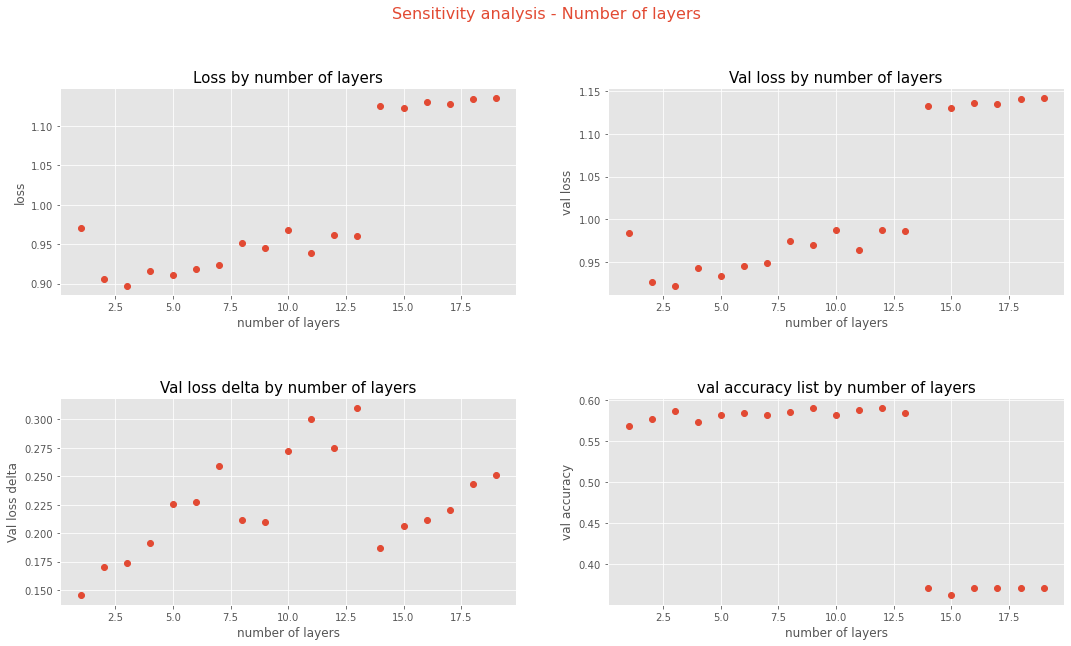

In [25]:
fig, axs = plt.subplots(2, 2, figsize=(18, 9.5))
fig.suptitle('Sensitivity analysis - Number of layers', y=1 , color='C0', size='16')
fig.subplots_adjust(hspace=0.5)
axs[0][0].plot(range_of_layers, loss_list, 'o')
axs[0][0].set_title('Loss by number of layers', fontsize=15)
axs[0][0].set_xlabel('number of layers')
axs[0][0].set_ylabel('loss')

axs[0][1].plot(range_of_layers, val_loss_list, 'o')
axs[0][1].set_title('Val loss by number of layers', fontsize=15)
axs[0][1].set_xlabel('number of layers')
axs[0][1].set_ylabel('val loss')

axs[1][0].plot(range_of_layers, val_loss_delta_list, 'o')
axs[1][0].set_title('Val loss delta by number of layers', fontsize=15)
axs[1][0].set_xlabel('number of layers')
axs[1][0].set_ylabel('Val loss delta')

axs[1][1].plot(range_of_layers, val_accuracy_list, 'o')
axs[1][1].set_title('val accuracy list by number of layers', fontsize=15)
axs[1][1].set_xlabel('number of layers')
axs[1][1].set_ylabel('val accuracy')

In [26]:
# activation function
loss_list = []
val_loss_list = []
val_loss_delta_list = []
val_accuracy_list = []
activation_function_list = ['relu','linear','selu','tanh','sigmoid']
for i in activation_function_list:
    model, history = run_model(3,[16]*3, [0]*3, i, 'Adagrad')
    loss_list.append(history.history['loss'][-1])
    val_loss_list.append(history.history['val_loss'][-1])
    val_loss_delta_list.append(history.history['val_loss'][0] - history.history['val_loss'][-1])
    val_accuracy_list.append(history.history['val_categorical_accuracy'][-1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 5

Epoch 5/40
16714/16714 - 1s - loss: 0.9552 - categorical_accuracy: 0.5964 - val_loss: 0.9724 - val_categorical_accuracy: 0.5733
Epoch 6/40
16714/16714 - 1s - loss: 0.9462 - categorical_accuracy: 0.5973 - val_loss: 0.9658 - val_categorical_accuracy: 0.5731
Epoch 7/40
16714/16714 - 1s - loss: 0.9400 - categorical_accuracy: 0.5979 - val_loss: 0.9612 - val_categorical_accuracy: 0.5729
Epoch 8/40
16714/16714 - 1s - loss: 0.9355 - categorical_accuracy: 0.5989 - val_loss: 0.9578 - val_categorical_accuracy: 0.5736
Epoch 9/40
16714/16714 - 1s - loss: 0.9321 - categorical_accuracy: 0.5995 - val_loss: 0.9552 - val_categorical_accuracy: 0.5745
Epoch 10/40
16714/16714 - 1s - loss: 0.9294 - categorical_accuracy: 0.6001 - val_loss: 0.9531 - val_categorical_accuracy: 0.5755
Epoch 11/40
16714/16714 - 1s - loss: 0.9273 - categorical_accuracy: 0.6003 - val_loss: 0.9513 - val_categorical_accuracy: 0.5757
Epoch 12/40
16714/16714 - 1s - loss: 0.9256 - categorical_accuracy: 0.6006 - val_loss: 0.9499 - val_ca

Epoch 19/40
16714/16714 - 1s - loss: 0.9282 - categorical_accuracy: 0.6014 - val_loss: 0.9501 - val_categorical_accuracy: 0.5810
Epoch 20/40
16714/16714 - 1s - loss: 0.9268 - categorical_accuracy: 0.6027 - val_loss: 0.9489 - val_categorical_accuracy: 0.5817
Epoch 21/40
16714/16714 - 1s - loss: 0.9254 - categorical_accuracy: 0.6036 - val_loss: 0.9477 - val_categorical_accuracy: 0.5817
Epoch 22/40
16714/16714 - 1s - loss: 0.9242 - categorical_accuracy: 0.6046 - val_loss: 0.9466 - val_categorical_accuracy: 0.5827
Epoch 23/40
16714/16714 - 1s - loss: 0.9230 - categorical_accuracy: 0.6054 - val_loss: 0.9456 - val_categorical_accuracy: 0.5832
Epoch 24/40
16714/16714 - 1s - loss: 0.9219 - categorical_accuracy: 0.6066 - val_loss: 0.9447 - val_categorical_accuracy: 0.5836
Epoch 25/40
16714/16714 - 1s - loss: 0.9209 - categorical_accuracy: 0.6069 - val_loss: 0.9438 - val_categorical_accuracy: 0.5846
Epoch 26/40
16714/16714 - 1s - loss: 0.9199 - categorical_accuracy: 0.6072 - val_loss: 0.9430 - v

Epoch 33/40
16714/16714 - 1s - loss: 0.9245 - categorical_accuracy: 0.6004 - val_loss: 0.9465 - val_categorical_accuracy: 0.5810
Epoch 34/40
16714/16714 - 1s - loss: 0.9238 - categorical_accuracy: 0.6009 - val_loss: 0.9459 - val_categorical_accuracy: 0.5815
Epoch 35/40
16714/16714 - 1s - loss: 0.9232 - categorical_accuracy: 0.6017 - val_loss: 0.9453 - val_categorical_accuracy: 0.5803
Epoch 36/40
16714/16714 - 1s - loss: 0.9226 - categorical_accuracy: 0.6017 - val_loss: 0.9447 - val_categorical_accuracy: 0.5796
Epoch 37/40
16714/16714 - 1s - loss: 0.9220 - categorical_accuracy: 0.6021 - val_loss: 0.9442 - val_categorical_accuracy: 0.5798
Epoch 38/40
16714/16714 - 1s - loss: 0.9215 - categorical_accuracy: 0.6021 - val_loss: 0.9436 - val_categorical_accuracy: 0.5796
Epoch 39/40
16714/16714 - 1s - loss: 0.9209 - categorical_accuracy: 0.6023 - val_loss: 0.9431 - val_categorical_accuracy: 0.5810
Epoch 40/40
16714/16714 - 1s - loss: 0.9204 - categorical_accuracy: 0.6025 - val_loss: 0.9427 - v

Text(0, 0.5, 'val accuracy')

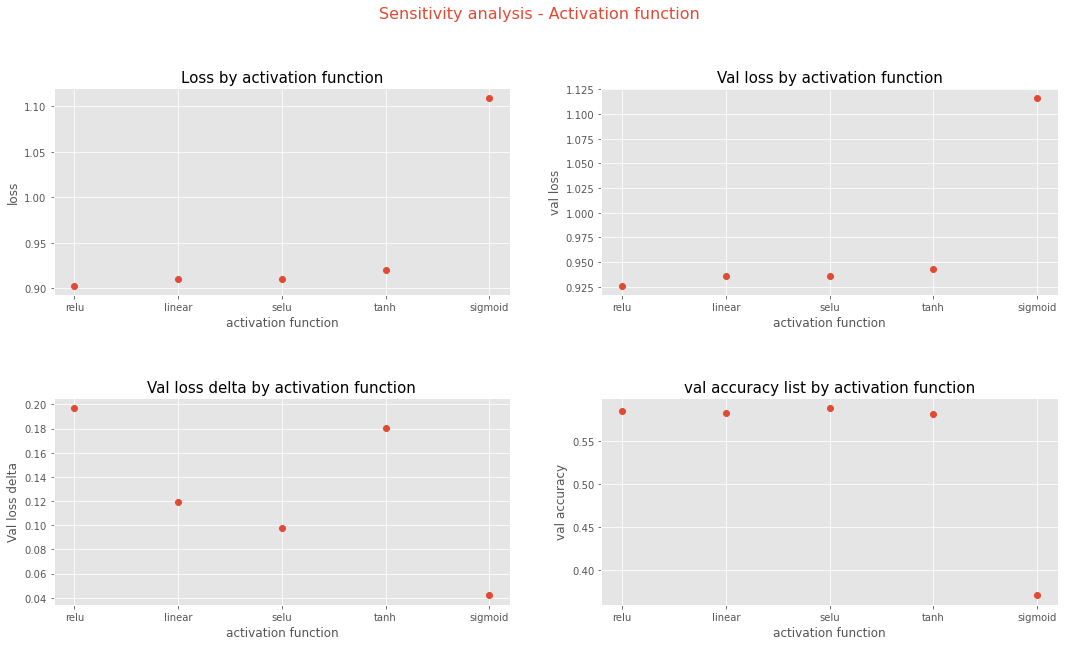

In [27]:
fig, axs = plt.subplots(2, 2, figsize=(18, 9.5))
fig.suptitle('Sensitivity analysis - Activation function', y=1 , color='C0', size='16')
fig.subplots_adjust(hspace=0.5)
axs[0][0].plot(activation_function_list, loss_list, 'o')
axs[0][0].set_title('Loss by activation function', fontsize=15)
axs[0][0].set_xlabel('activation function')
axs[0][0].set_ylabel('loss')

axs[0][1].plot(activation_function_list, val_loss_list, 'o')
axs[0][1].set_title('Val loss by activation function', fontsize=15)
axs[0][1].set_xlabel('activation function')
axs[0][1].set_ylabel('val loss')

axs[1][0].plot(activation_function_list, val_loss_delta_list, 'o')
axs[1][0].set_title('Val loss delta by activation function', fontsize=15)
axs[1][0].set_xlabel('activation function')
axs[1][0].set_ylabel('Val loss delta')

axs[1][1].plot(activation_function_list, val_accuracy_list, 'o')
axs[1][1].set_title('val accuracy list by activation function', fontsize=15)
axs[1][1].set_xlabel('activation function')
axs[1][1].set_ylabel('val accuracy')

In [28]:
# optimizer
loss_list = []
val_loss_list = []
val_loss_delta_list = []
val_accuracy_list = []
optimizer_list =['SGD','Adam', 'Adamax', 'Adagrad', 'Adadelta','RMSprop', 'Ftrl','Nadam']
for i in optimizer_list:
    model, history = run_model(3,[16]*3, [0]*3, 'relu', i)
    loss_list.append(history.history['loss'][-1])
    val_loss_list.append(history.history['val_loss'][-1])
    val_loss_delta_list.append(history.history['val_loss'][0] - history.history['val_loss'][-1])
    val_accuracy_list.append(history.history['val_categorical_accuracy'][-1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                224       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 5

Epoch 5/40
16714/16714 - 1s - loss: 0.8731 - categorical_accuracy: 0.6111 - val_loss: 0.8947 - val_categorical_accuracy: 0.5982
Epoch 6/40
16714/16714 - 1s - loss: 0.8710 - categorical_accuracy: 0.6132 - val_loss: 0.8926 - val_categorical_accuracy: 0.5992
Epoch 7/40
16714/16714 - 1s - loss: 0.8691 - categorical_accuracy: 0.6137 - val_loss: 0.8910 - val_categorical_accuracy: 0.6006
Epoch 8/40
16714/16714 - 1s - loss: 0.8674 - categorical_accuracy: 0.6141 - val_loss: 0.8893 - val_categorical_accuracy: 0.6021
Epoch 9/40
16714/16714 - 1s - loss: 0.8659 - categorical_accuracy: 0.6151 - val_loss: 0.8881 - val_categorical_accuracy: 0.6021
Epoch 10/40
16714/16714 - 1s - loss: 0.8646 - categorical_accuracy: 0.6160 - val_loss: 0.8869 - val_categorical_accuracy: 0.6033
Epoch 11/40
16714/16714 - 1s - loss: 0.8633 - categorical_accuracy: 0.6160 - val_loss: 0.8857 - val_categorical_accuracy: 0.6030
Epoch 12/40
16714/16714 - 1s - loss: 0.8623 - categorical_accuracy: 0.6168 - val_loss: 0.8849 - val_ca

Epoch 19/40
16714/16714 - 1s - loss: 0.8679 - categorical_accuracy: 0.6177 - val_loss: 0.8928 - val_categorical_accuracy: 0.5985
Epoch 20/40
16714/16714 - 1s - loss: 0.8671 - categorical_accuracy: 0.6184 - val_loss: 0.8921 - val_categorical_accuracy: 0.5987
Epoch 21/40
16714/16714 - 1s - loss: 0.8664 - categorical_accuracy: 0.6186 - val_loss: 0.8914 - val_categorical_accuracy: 0.5994
Epoch 22/40
16714/16714 - 1s - loss: 0.8657 - categorical_accuracy: 0.6189 - val_loss: 0.8908 - val_categorical_accuracy: 0.6001
Epoch 23/40
16714/16714 - 1s - loss: 0.8651 - categorical_accuracy: 0.6186 - val_loss: 0.8902 - val_categorical_accuracy: 0.6018
Epoch 24/40
16714/16714 - 1s - loss: 0.8644 - categorical_accuracy: 0.6187 - val_loss: 0.8895 - val_categorical_accuracy: 0.6013
Epoch 25/40
16714/16714 - 1s - loss: 0.8638 - categorical_accuracy: 0.6192 - val_loss: 0.8889 - val_categorical_accuracy: 0.6016
Epoch 26/40
16714/16714 - 1s - loss: 0.8632 - categorical_accuracy: 0.6197 - val_loss: 0.8883 - v

Epoch 33/40
16714/16714 - 1s - loss: 0.9300 - categorical_accuracy: 0.5899 - val_loss: 0.9523 - val_categorical_accuracy: 0.5707
Epoch 34/40
16714/16714 - 1s - loss: 0.9286 - categorical_accuracy: 0.5906 - val_loss: 0.9511 - val_categorical_accuracy: 0.5702
Epoch 35/40
16714/16714 - 1s - loss: 0.9273 - categorical_accuracy: 0.5909 - val_loss: 0.9499 - val_categorical_accuracy: 0.5707
Epoch 36/40
16714/16714 - 1s - loss: 0.9261 - categorical_accuracy: 0.5912 - val_loss: 0.9487 - val_categorical_accuracy: 0.5709
Epoch 37/40
16714/16714 - 1s - loss: 0.9249 - categorical_accuracy: 0.5912 - val_loss: 0.9476 - val_categorical_accuracy: 0.5705
Epoch 38/40
16714/16714 - 1s - loss: 0.9238 - categorical_accuracy: 0.5915 - val_loss: 0.9466 - val_categorical_accuracy: 0.5712
Epoch 39/40
16714/16714 - 1s - loss: 0.9227 - categorical_accuracy: 0.5921 - val_loss: 0.9456 - val_categorical_accuracy: 0.5709
Epoch 40/40
16714/16714 - 1s - loss: 0.9216 - categorical_accuracy: 0.5921 - val_loss: 0.9446 - v

Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 1s - loss: 0.9709 - categorical_accuracy: 0.5748 - val_loss: 0.9141 - val_categorical_accuracy: 0.5779
Epoch 2/40
16714/16714 - 1s - loss: 0.8803 - categorical_accuracy: 0.6064 - val_loss: 0.9063 - val_categorical_accuracy: 0.5844
Epoch 3/40
16714/16714 - 1s - loss: 0.8752 - categorical_accuracy: 0.6087 - val_loss: 0.9034 - val_categorical_accuracy: 0.5846
Epoch 4/40
16714/16714 - 1s - loss: 0.8726 - categorical_accuracy: 0.6112 - val_loss: 0.9005 - val_categorical_accuracy: 0.5877
Epoch 5/40
16714/16714 - 1s - loss: 0.8705 - categorical_accuracy: 0.6116 - val_loss: 0.8987 - val_categorical_accuracy: 0.5896
Epoch 6/40
16714/16714 - 1s - loss: 0.8687 - categorical_accuracy: 0.6133 - val_loss: 0.8969 - val_categorical_accuracy: 0.5915
Epoch 7/40
16714/16714 - 1s - loss: 0.8672 - categorical_accuracy: 0.6142 - val_loss: 0.8956 - val_categorical_accuracy: 0.5932
Epoch 8/40
16714/16714 - 1s - loss: 0.8657 - categorica

16714/16714 - 1s - loss: 1.0882 - categorical_accuracy: 0.3757 - val_loss: 1.0908 - val_categorical_accuracy: 0.3707
Epoch 15/40
16714/16714 - 1s - loss: 1.0879 - categorical_accuracy: 0.3757 - val_loss: 1.0907 - val_categorical_accuracy: 0.3707
Epoch 16/40
16714/16714 - 1s - loss: 1.0877 - categorical_accuracy: 0.3757 - val_loss: 1.0906 - val_categorical_accuracy: 0.3707
Epoch 17/40
16714/16714 - 1s - loss: 1.0875 - categorical_accuracy: 0.3757 - val_loss: 1.0905 - val_categorical_accuracy: 0.3707
Epoch 18/40
16714/16714 - 1s - loss: 1.0873 - categorical_accuracy: 0.3757 - val_loss: 1.0903 - val_categorical_accuracy: 0.3707
Epoch 19/40
16714/16714 - 1s - loss: 1.0871 - categorical_accuracy: 0.3757 - val_loss: 1.0902 - val_categorical_accuracy: 0.3707
Epoch 20/40
16714/16714 - 1s - loss: 1.0870 - categorical_accuracy: 0.3757 - val_loss: 1.0901 - val_categorical_accuracy: 0.3707
Epoch 21/40
16714/16714 - 1s - loss: 1.0868 - categorical_accuracy: 0.3757 - val_loss: 1.0900 - val_categoric

Epoch 28/40
16714/16714 - 1s - loss: 0.8454 - categorical_accuracy: 0.6225 - val_loss: 0.8688 - val_categorical_accuracy: 0.6052
Epoch 29/40
16714/16714 - 1s - loss: 0.8450 - categorical_accuracy: 0.6223 - val_loss: 0.8684 - val_categorical_accuracy: 0.6066
Epoch 30/40
16714/16714 - 1s - loss: 0.8446 - categorical_accuracy: 0.6230 - val_loss: 0.8683 - val_categorical_accuracy: 0.6066
Epoch 31/40
16714/16714 - 1s - loss: 0.8443 - categorical_accuracy: 0.6228 - val_loss: 0.8679 - val_categorical_accuracy: 0.6061
Epoch 32/40
16714/16714 - 1s - loss: 0.8439 - categorical_accuracy: 0.6224 - val_loss: 0.8677 - val_categorical_accuracy: 0.6054
Epoch 33/40
16714/16714 - 1s - loss: 0.8435 - categorical_accuracy: 0.6221 - val_loss: 0.8674 - val_categorical_accuracy: 0.6064
Epoch 34/40
16714/16714 - 1s - loss: 0.8432 - categorical_accuracy: 0.6224 - val_loss: 0.8672 - val_categorical_accuracy: 0.6052
Epoch 35/40
16714/16714 - 1s - loss: 0.8429 - categorical_accuracy: 0.6223 - val_loss: 0.8671 - v

Text(0, 0.5, 'val accuracy')

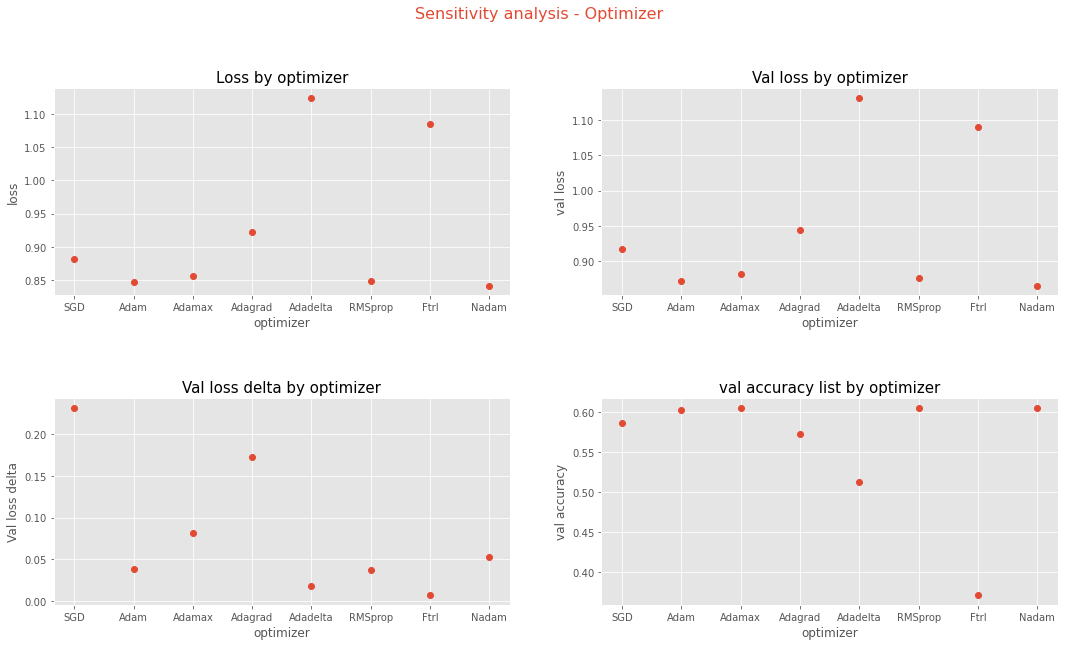

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(18, 9.5))
fig.suptitle('Sensitivity analysis - Optimizer', y=1 , color='C0', size='16')
fig.subplots_adjust(hspace=0.5)
axs[0][0].plot(optimizer_list, loss_list, 'o')
axs[0][0].set_title('Loss by optimizer', fontsize=15)
axs[0][0].set_xlabel('optimizer')
axs[0][0].set_ylabel('loss')

axs[0][1].plot(optimizer_list, val_loss_list, 'o')
axs[0][1].set_title('Val loss by optimizer', fontsize=15)
axs[0][1].set_xlabel('optimizer')
axs[0][1].set_ylabel('val loss')

axs[1][0].plot(optimizer_list, val_loss_delta_list, 'o')
axs[1][0].set_title('Val loss delta by optimizer', fontsize=15)
axs[1][0].set_xlabel('optimizer')
axs[1][0].set_ylabel('Val loss delta')

axs[1][1].plot(optimizer_list, val_accuracy_list, 'o')
axs[1][1].set_title('val accuracy list by optimizer', fontsize=15)
axs[1][1].set_xlabel('optimizer')
axs[1][1].set_ylabel('val accuracy')

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Random search</font>

In [30]:
# performing random search on the following hyper parameters:
    # number of layers 
    # number of units in each layer 
    # activation function
    # optimizer
optimizer_list =['SGD','Adam', 'Adamax', 'Adagrad', 'Adadelta','RMSprop', 'Ftrl','Nadam']
activation_function_list = ['relu','linear','selu','tanh','sigmoid']
loss_list = []
val_loss_list = []
val_accuracy_list = []
evaluations = 30

# set seeds to make the random search to be with the same set of hyper-parameters
np.random.seed(0)
num_units_list= np.random.uniform(low=1, high=50, size=(evaluations,))

np.random.seed(56)
num_layers_list= np.random.uniform(low=1, high=17, size=(evaluations,))

np.random.seed(99)
optimizers_indexes= np.random.uniform(low=0, high=len(optimizer_list)-1, size=(evaluations,))

np.random.seed(98)
activation_functions_indexes= np.random.uniform(low=0, high=len(activation_function_list)-1, size=(evaluations,))


# variables to record the results
val_loss_list = []
results = pd.DataFrame(columns = ['Evaluation', '# of layers', '# of units per layer', 'Activation function',
                                  'Optimizer', 'Val loss', 'Val loss Delta', 'MSE', '# of params','BIC', 'AIC'
                                 ], index = list(range(evaluations)))

# in each evaluation we are genarting diffrent set of hyper-parameters and train the model with them
for eval in range(evaluations):
    print("*******************************************************************************************")
    print('Evaluation #{}'.format(eval+1))
    
    num_layers = int(num_layers_list[eval])
    num_units = int(num_units_list[eval])
    activation_function = activation_function_list[int(activation_functions_indexes[eval])]
    optimizer = optimizer_list[int(optimizers_indexes[eval])]
    print("# of layers: %d; # of units per layer: %d; Activation function: %s; Optimizer: %s;" 
          % (num_layers, num_units, activation_function, optimizer))
    model, history = run_model(num_layers,[num_units]*num_layers, [0]*num_layers, activation_function, optimizer)
    val_loss_delta = history.history['val_loss'][0] - history.history['val_loss'][-1]
    results.loc[eval, ['Evaluation']] = eval+1
    results.loc[eval, ['# of layers']] = num_layers
    results.loc[eval, ['# of units per layer']] = num_units
    results.loc[eval, ['Activation function']] = activation_function
    results.loc[eval, ['Optimizer']] = optimizer
    results.loc[eval, ['Val loss']] = history.history['val_loss'][-1]
    results.loc[eval, ['Val loss Delta']] = val_loss_delta

    loss_list.append(history.history['loss'])
    val_loss_list.append(history.history['val_loss'])
    val_accuracy_list.append(history.history['val_categorical_accuracy'])
    
    # calculating BIC and AIC to find the best model
    #get k - number of params
    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    k = (trainable_count+non_trainable_count)
    results.loc[eval, ['# of params']] = k
    #get n - number of data points
    n = x_train.shape[0]
    #get e - network error
    prediction_matrix = model.predict(x=x_train, batch_size=32, verbose=2)
    prediction_result = np.argmax(prediction_matrix, axis=-1)
    e = get_error(y_train, prediction_result)
    results.loc[eval, ['MSE']] = e
    BIC = n*np.log(e)+k*np.log(n)
    AIC = n*np.log(e)+2*k
    results.loc[eval, ['BIC']] = BIC 
    results.loc[eval, ['AIC']] = AIC 
       

*******************************************************************************************
Evaluation #1
# of layers: 16; # of units per layer: 27; Activation function: selu; Optimizer: Adadelta;
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 27)                378       
_________________________________________________________________
dropout_1 (Dropout)          (None, 27)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 27)                756       
_________________________________________________________________
dropout_2 (Dropout)          (None, 27)                0         
_________________________________________________________

Epoch 27/40
16714/16714 - 1s - loss: 1.4847 - categorical_accuracy: 0.5993 - val_loss: 1.5135 - val_categorical_accuracy: 0.5769
Epoch 28/40
16714/16714 - 1s - loss: 1.4838 - categorical_accuracy: 0.5993 - val_loss: 1.5126 - val_categorical_accuracy: 0.5793
Epoch 29/40
16714/16714 - 1s - loss: 1.4830 - categorical_accuracy: 0.6000 - val_loss: 1.5117 - val_categorical_accuracy: 0.5798
Epoch 30/40
16714/16714 - 1s - loss: 1.4821 - categorical_accuracy: 0.6002 - val_loss: 1.5108 - val_categorical_accuracy: 0.5800
Epoch 31/40
16714/16714 - 1s - loss: 1.4814 - categorical_accuracy: 0.6006 - val_loss: 1.5100 - val_categorical_accuracy: 0.5798
Epoch 32/40
16714/16714 - 1s - loss: 1.4806 - categorical_accuracy: 0.6015 - val_loss: 1.5092 - val_categorical_accuracy: 0.5815
Epoch 33/40
16714/16714 - 1s - loss: 1.4799 - categorical_accuracy: 0.6018 - val_loss: 1.5085 - val_categorical_accuracy: 0.5824
Epoch 34/40
16714/16714 - 1s - loss: 1.4792 - categorical_accuracy: 0.6018 - val_loss: 1.5078 - v

Epoch 33/40
16714/16714 - 1s - loss: 1.1117 - categorical_accuracy: 0.6203 - val_loss: 1.1414 - val_categorical_accuracy: 0.5994
Epoch 34/40
16714/16714 - 1s - loss: 1.1111 - categorical_accuracy: 0.6204 - val_loss: 1.1408 - val_categorical_accuracy: 0.5994
Epoch 35/40
16714/16714 - 1s - loss: 1.1106 - categorical_accuracy: 0.6207 - val_loss: 1.1402 - val_categorical_accuracy: 0.5997
Epoch 36/40
16714/16714 - 1s - loss: 1.1100 - categorical_accuracy: 0.6204 - val_loss: 1.1397 - val_categorical_accuracy: 0.5999
Epoch 37/40
16714/16714 - 1s - loss: 1.1095 - categorical_accuracy: 0.6204 - val_loss: 1.1392 - val_categorical_accuracy: 0.6001
Epoch 38/40
16714/16714 - 1s - loss: 1.1090 - categorical_accuracy: 0.6206 - val_loss: 1.1387 - val_categorical_accuracy: 0.6004
Epoch 39/40
16714/16714 - 1s - loss: 1.1085 - categorical_accuracy: 0.6207 - val_loss: 1.1382 - val_categorical_accuracy: 0.6006
Epoch 40/40
16714/16714 - 1s - loss: 1.1080 - categorical_accuracy: 0.6207 - val_loss: 1.1377 - v

Epoch 29/40
16714/16714 - 1s - loss: 0.8749 - categorical_accuracy: 0.6061 - val_loss: 0.9112 - val_categorical_accuracy: 0.5834
Epoch 30/40
16714/16714 - 1s - loss: 0.8745 - categorical_accuracy: 0.6061 - val_loss: 0.9106 - val_categorical_accuracy: 0.5834
Epoch 31/40
16714/16714 - 1s - loss: 0.8742 - categorical_accuracy: 0.6060 - val_loss: 0.9099 - val_categorical_accuracy: 0.5836
Epoch 32/40
16714/16714 - 1s - loss: 0.8739 - categorical_accuracy: 0.6060 - val_loss: 0.9094 - val_categorical_accuracy: 0.5836
Epoch 33/40
16714/16714 - 1s - loss: 0.8737 - categorical_accuracy: 0.6060 - val_loss: 0.9090 - val_categorical_accuracy: 0.5839
Epoch 34/40
16714/16714 - 1s - loss: 0.8735 - categorical_accuracy: 0.6060 - val_loss: 0.9088 - val_categorical_accuracy: 0.5836
Epoch 35/40
16714/16714 - 1s - loss: 0.8733 - categorical_accuracy: 0.6060 - val_loss: 0.9084 - val_categorical_accuracy: 0.5839
Epoch 36/40
16714/16714 - 1s - loss: 0.8731 - categorical_accuracy: 0.6061 - val_loss: 0.9080 - v

Epoch 39/40
16714/16714 - 1s - loss: 0.9127 - categorical_accuracy: 0.6145 - val_loss: 0.9473 - val_categorical_accuracy: 0.5913
Epoch 40/40
16714/16714 - 1s - loss: 0.9115 - categorical_accuracy: 0.6145 - val_loss: 0.9460 - val_categorical_accuracy: 0.5911
16714/16714 - 0s
*******************************************************************************************
Evaluation #5
# of layers: 6; # of units per layer: 21; Activation function: linear; Optimizer: RMSprop;
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 21)                294       
_________________________________________________________________
dropout_1 (Dropout)          (None, 21)                0         
______________________________________________

Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 3s - loss: 1.5864 - categorical_accuracy: 0.3746 - val_loss: 1.5250 - val_categorical_accuracy: 0.3620
Epoch 2/40
16714/16714 - 1s - loss: 1.4822 - categorical_accuracy: 0.3746 - val_loss: 1.4573 - val_categorical_accuracy: 0.3620
Epoch 3/40
16714/16714 - 1s - loss: 1.4266 - categorical_accuracy: 0.3746 - val_loss: 1.4114 - val_categorical_accuracy: 0.3620
Epoch 4/40
16714/16714 - 1s - loss: 1.3866 - categorical_accuracy: 0.3746 - val_loss: 1.3765 - val_categorical_accuracy: 0.3620
Epoch 5/40
16714/16714 - 1s - loss: 1.3552 - categorical_accuracy: 0.3746 - val_loss: 1.3484 - val_categorical_accuracy: 0.3620
Epoch 6/40
16714/16714 - 1s - loss: 1.3296 - categorical_accuracy: 0.3746 - val_loss: 1.3249 - val_categorical_accuracy: 0.3620
Epoch 7/40
16714/16714 - 1s - loss: 1.3079 - categorical_accuracy: 0.3746 - val_loss: 1.3049 - val_categorical_accuracy: 0.3620
Epoch 8/40
16714/16714 - 1s - loss: 1.2893 - categorica

Epoch 11/40
16714/16714 - 1s - loss: 0.8914 - categorical_accuracy: 0.6142 - val_loss: 0.9134 - val_categorical_accuracy: 0.5982
Epoch 12/40
16714/16714 - 1s - loss: 0.8886 - categorical_accuracy: 0.6145 - val_loss: 0.9107 - val_categorical_accuracy: 0.5987
Epoch 13/40
16714/16714 - 1s - loss: 0.8861 - categorical_accuracy: 0.6146 - val_loss: 0.9083 - val_categorical_accuracy: 0.5982
Epoch 14/40
16714/16714 - 1s - loss: 0.8840 - categorical_accuracy: 0.6145 - val_loss: 0.9063 - val_categorical_accuracy: 0.5980
Epoch 15/40
16714/16714 - 1s - loss: 0.8821 - categorical_accuracy: 0.6143 - val_loss: 0.9044 - val_categorical_accuracy: 0.5982
Epoch 16/40
16714/16714 - 1s - loss: 0.8804 - categorical_accuracy: 0.6143 - val_loss: 0.9028 - val_categorical_accuracy: 0.5980
Epoch 17/40
16714/16714 - 1s - loss: 0.8788 - categorical_accuracy: 0.6143 - val_loss: 0.9013 - val_categorical_accuracy: 0.5982
Epoch 18/40
16714/16714 - 1s - loss: 0.8774 - categorical_accuracy: 0.6143 - val_loss: 0.9000 - v

Epoch 13/40
16714/16714 - 1s - loss: 1.2363 - categorical_accuracy: 0.6131 - val_loss: 1.2854 - val_categorical_accuracy: 0.5717
Epoch 14/40
16714/16714 - 1s - loss: 1.2279 - categorical_accuracy: 0.6132 - val_loss: 1.2757 - val_categorical_accuracy: 0.5736
Epoch 15/40
16714/16714 - 1s - loss: 1.2197 - categorical_accuracy: 0.6132 - val_loss: 1.2664 - val_categorical_accuracy: 0.5741
Epoch 16/40
16714/16714 - 1s - loss: 1.2117 - categorical_accuracy: 0.6131 - val_loss: 1.2574 - val_categorical_accuracy: 0.5757
Epoch 17/40
16714/16714 - 1s - loss: 1.2039 - categorical_accuracy: 0.6132 - val_loss: 1.2487 - val_categorical_accuracy: 0.5767
Epoch 18/40
16714/16714 - 1s - loss: 1.1962 - categorical_accuracy: 0.6130 - val_loss: 1.2403 - val_categorical_accuracy: 0.5769
Epoch 19/40
16714/16714 - 1s - loss: 1.1887 - categorical_accuracy: 0.6128 - val_loss: 1.2321 - val_categorical_accuracy: 0.5772
Epoch 20/40
16714/16714 - 1s - loss: 1.1815 - categorical_accuracy: 0.6130 - val_loss: 1.2242 - v

Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 3s - loss: 1.0996 - categorical_accuracy: 0.3730 - val_loss: 1.0966 - val_categorical_accuracy: 0.3707
Epoch 2/40
16714/16714 - 1s - loss: 1.0950 - categorical_accuracy: 0.3689 - val_loss: 1.0954 - val_categorical_accuracy: 0.3707
Epoch 3/40
16714/16714 - 1s - loss: 1.0937 - categorical_accuracy: 0.3734 - val_loss: 1.0946 - val_categorical_accuracy: 0.3707
Epoch 4/40
16714/16714 - 1s - loss: 1.0927 - categorical_accuracy: 0.3757 - val_loss: 1.0939 - val_categorical_accuracy: 0.3707
Epoch 5/40
16714/16714 - 1s - loss: 1.0920 - categorical_accuracy: 0.3757 - val_loss: 1.0934 - val_categorical_accuracy: 0.3707
Epoch 6/40
16714/16714 - 1s - loss: 1.0913 - categorical_accuracy: 0.3757 - val_loss: 1.0930 - val_categorical_accuracy: 0.3707
Epoch 7/40
16714/16714 - 1s - loss: 1.0908 - categorical_accuracy: 0.3757 - val_loss: 1.0926 - val_categorical_accuracy: 0.3707
Epoch 8/40
16714/16714 - 1s - loss: 1.0903 - categorica

Epoch 5/40
16714/16714 - 1s - loss: 1.2383 - categorical_accuracy: 0.4423 - val_loss: 1.2421 - val_categorical_accuracy: 0.4207
Epoch 6/40
16714/16714 - 1s - loss: 1.2299 - categorical_accuracy: 0.5342 - val_loss: 1.2304 - val_categorical_accuracy: 0.5334
Epoch 7/40
16714/16714 - 1s - loss: 1.2081 - categorical_accuracy: 0.5748 - val_loss: 1.1946 - val_categorical_accuracy: 0.5709
Epoch 8/40
16714/16714 - 1s - loss: 1.1334 - categorical_accuracy: 0.5896 - val_loss: 1.1105 - val_categorical_accuracy: 0.5547
Epoch 9/40
16714/16714 - 1s - loss: 1.0418 - categorical_accuracy: 0.5972 - val_loss: 1.1135 - val_categorical_accuracy: 0.5384
Epoch 10/40
16714/16714 - 1s - loss: 1.0159 - categorical_accuracy: 0.5999 - val_loss: 1.1133 - val_categorical_accuracy: 0.5372
Epoch 11/40
16714/16714 - 1s - loss: 1.0073 - categorical_accuracy: 0.6021 - val_loss: 1.1087 - val_categorical_accuracy: 0.5379
Epoch 12/40
16714/16714 - 1s - loss: 1.0019 - categorical_accuracy: 0.6037 - val_loss: 1.1046 - val_ca

Epoch 11/40
16714/16714 - 1s - loss: 0.8738 - categorical_accuracy: 0.6058 - val_loss: 0.9103 - val_categorical_accuracy: 0.5812
Epoch 12/40
16714/16714 - 1s - loss: 0.8727 - categorical_accuracy: 0.6061 - val_loss: 0.9087 - val_categorical_accuracy: 0.5817
Epoch 13/40
16714/16714 - 1s - loss: 0.8716 - categorical_accuracy: 0.6061 - val_loss: 0.9071 - val_categorical_accuracy: 0.5817
Epoch 14/40
16714/16714 - 1s - loss: 0.8708 - categorical_accuracy: 0.6063 - val_loss: 0.9058 - val_categorical_accuracy: 0.5820
Epoch 15/40
16714/16714 - 1s - loss: 0.8700 - categorical_accuracy: 0.6063 - val_loss: 0.9044 - val_categorical_accuracy: 0.5824
Epoch 16/40
16714/16714 - 1s - loss: 0.8694 - categorical_accuracy: 0.6060 - val_loss: 0.9033 - val_categorical_accuracy: 0.5832
Epoch 17/40
16714/16714 - 1s - loss: 0.8689 - categorical_accuracy: 0.6061 - val_loss: 0.9026 - val_categorical_accuracy: 0.5832
Epoch 18/40
16714/16714 - 1s - loss: 0.8685 - categorical_accuracy: 0.6061 - val_loss: 0.9017 - v

Epoch 25/40
16714/16714 - 1s - loss: 0.8543 - categorical_accuracy: 0.6157 - val_loss: 0.8804 - val_categorical_accuracy: 0.5932
Epoch 26/40
16714/16714 - 1s - loss: 0.8540 - categorical_accuracy: 0.6158 - val_loss: 0.8799 - val_categorical_accuracy: 0.5934
Epoch 27/40
16714/16714 - 1s - loss: 0.8538 - categorical_accuracy: 0.6159 - val_loss: 0.8796 - val_categorical_accuracy: 0.5934
Epoch 28/40
16714/16714 - 1s - loss: 0.8535 - categorical_accuracy: 0.6161 - val_loss: 0.8792 - val_categorical_accuracy: 0.5934
Epoch 29/40
16714/16714 - 1s - loss: 0.8533 - categorical_accuracy: 0.6161 - val_loss: 0.8789 - val_categorical_accuracy: 0.5939
Epoch 30/40
16714/16714 - 1s - loss: 0.8531 - categorical_accuracy: 0.6157 - val_loss: 0.8787 - val_categorical_accuracy: 0.5932
Epoch 31/40
16714/16714 - 1s - loss: 0.8530 - categorical_accuracy: 0.6155 - val_loss: 0.8785 - val_categorical_accuracy: 0.5939
Epoch 32/40
16714/16714 - 1s - loss: 0.8529 - categorical_accuracy: 0.6155 - val_loss: 0.8785 - v

Epoch 15/40
16714/16714 - 1s - loss: 0.9464 - categorical_accuracy: 0.6091 - val_loss: 0.9663 - val_categorical_accuracy: 0.5942
Epoch 16/40
16714/16714 - 1s - loss: 0.9409 - categorical_accuracy: 0.6091 - val_loss: 0.9608 - val_categorical_accuracy: 0.5913
Epoch 17/40
16714/16714 - 1s - loss: 0.9350 - categorical_accuracy: 0.6088 - val_loss: 0.9547 - val_categorical_accuracy: 0.5908
Epoch 18/40
16714/16714 - 1s - loss: 0.9290 - categorical_accuracy: 0.6090 - val_loss: 0.9491 - val_categorical_accuracy: 0.5913
Epoch 19/40
16714/16714 - 1s - loss: 0.9239 - categorical_accuracy: 0.6089 - val_loss: 0.9444 - val_categorical_accuracy: 0.5913
Epoch 20/40
16714/16714 - 1s - loss: 0.9196 - categorical_accuracy: 0.6090 - val_loss: 0.9405 - val_categorical_accuracy: 0.5913
Epoch 21/40
16714/16714 - 1s - loss: 0.9160 - categorical_accuracy: 0.6091 - val_loss: 0.9373 - val_categorical_accuracy: 0.5918
Epoch 22/40
16714/16714 - 1s - loss: 0.9130 - categorical_accuracy: 0.6092 - val_loss: 0.9346 - v

Epoch 29/40
16714/16714 - 1s - loss: 0.9375 - categorical_accuracy: 0.6101 - val_loss: 0.9620 - val_categorical_accuracy: 0.5855
Epoch 30/40
16714/16714 - 1s - loss: 0.9369 - categorical_accuracy: 0.6099 - val_loss: 0.9614 - val_categorical_accuracy: 0.5855
Epoch 31/40
16714/16714 - 1s - loss: 0.9363 - categorical_accuracy: 0.6103 - val_loss: 0.9609 - val_categorical_accuracy: 0.5863
Epoch 32/40
16714/16714 - 1s - loss: 0.9358 - categorical_accuracy: 0.6106 - val_loss: 0.9604 - val_categorical_accuracy: 0.5867
Epoch 33/40
16714/16714 - 1s - loss: 0.9353 - categorical_accuracy: 0.6108 - val_loss: 0.9599 - val_categorical_accuracy: 0.5867
Epoch 34/40
16714/16714 - 1s - loss: 0.9347 - categorical_accuracy: 0.6109 - val_loss: 0.9594 - val_categorical_accuracy: 0.5867
Epoch 35/40
16714/16714 - 1s - loss: 0.9343 - categorical_accuracy: 0.6111 - val_loss: 0.9589 - val_categorical_accuracy: 0.5875
Epoch 36/40
16714/16714 - 1s - loss: 0.9338 - categorical_accuracy: 0.6116 - val_loss: 0.9585 - v

Epoch 25/40
16714/16714 - 1s - loss: 1.0859 - categorical_accuracy: 0.3757 - val_loss: 1.0895 - val_categorical_accuracy: 0.3707
Epoch 26/40
16714/16714 - 1s - loss: 1.0858 - categorical_accuracy: 0.3757 - val_loss: 1.0895 - val_categorical_accuracy: 0.3707
Epoch 27/40
16714/16714 - 1s - loss: 1.0856 - categorical_accuracy: 0.3757 - val_loss: 1.0894 - val_categorical_accuracy: 0.3707
Epoch 28/40
16714/16714 - 1s - loss: 1.0855 - categorical_accuracy: 0.3757 - val_loss: 1.0893 - val_categorical_accuracy: 0.3707
Epoch 29/40
16714/16714 - 1s - loss: 1.0854 - categorical_accuracy: 0.3757 - val_loss: 1.0893 - val_categorical_accuracy: 0.3707
Epoch 30/40
16714/16714 - 1s - loss: 1.0853 - categorical_accuracy: 0.3757 - val_loss: 1.0892 - val_categorical_accuracy: 0.3707
Epoch 31/40
16714/16714 - 1s - loss: 1.0851 - categorical_accuracy: 0.3757 - val_loss: 1.0891 - val_categorical_accuracy: 0.3707
Epoch 32/40
16714/16714 - 1s - loss: 1.0850 - categorical_accuracy: 0.3757 - val_loss: 1.0891 - v

Epoch 25/40
16714/16714 - 1s - loss: 0.8769 - categorical_accuracy: 0.6091 - val_loss: 0.9014 - val_categorical_accuracy: 0.5908
Epoch 26/40
16714/16714 - 1s - loss: 0.8765 - categorical_accuracy: 0.6091 - val_loss: 0.9010 - val_categorical_accuracy: 0.5908
Epoch 27/40
16714/16714 - 1s - loss: 0.8760 - categorical_accuracy: 0.6091 - val_loss: 0.9005 - val_categorical_accuracy: 0.5911
Epoch 28/40
16714/16714 - 1s - loss: 0.8757 - categorical_accuracy: 0.6094 - val_loss: 0.9001 - val_categorical_accuracy: 0.5911
Epoch 29/40
16714/16714 - 1s - loss: 0.8753 - categorical_accuracy: 0.6097 - val_loss: 0.8997 - val_categorical_accuracy: 0.5913
Epoch 30/40
16714/16714 - 1s - loss: 0.8749 - categorical_accuracy: 0.6097 - val_loss: 0.8993 - val_categorical_accuracy: 0.5908
Epoch 31/40
16714/16714 - 1s - loss: 0.8746 - categorical_accuracy: 0.6094 - val_loss: 0.8989 - val_categorical_accuracy: 0.5908
Epoch 32/40
16714/16714 - 1s - loss: 0.8742 - categorical_accuracy: 0.6093 - val_loss: 0.8985 - v

Epoch 15/40
16714/16714 - 1s - loss: 1.0879 - categorical_accuracy: 0.3757 - val_loss: 1.0907 - val_categorical_accuracy: 0.3707
Epoch 16/40
16714/16714 - 1s - loss: 1.0877 - categorical_accuracy: 0.3757 - val_loss: 1.0906 - val_categorical_accuracy: 0.3707
Epoch 17/40
16714/16714 - 1s - loss: 1.0875 - categorical_accuracy: 0.3757 - val_loss: 1.0905 - val_categorical_accuracy: 0.3707
Epoch 18/40
16714/16714 - 1s - loss: 1.0873 - categorical_accuracy: 0.3757 - val_loss: 1.0903 - val_categorical_accuracy: 0.3707
Epoch 19/40
16714/16714 - 1s - loss: 1.0871 - categorical_accuracy: 0.3757 - val_loss: 1.0902 - val_categorical_accuracy: 0.3707
Epoch 20/40
16714/16714 - 1s - loss: 1.0870 - categorical_accuracy: 0.3757 - val_loss: 1.0901 - val_categorical_accuracy: 0.3707
Epoch 21/40
16714/16714 - 1s - loss: 1.0868 - categorical_accuracy: 0.3757 - val_loss: 1.0900 - val_categorical_accuracy: 0.3707
Epoch 22/40
16714/16714 - 1s - loss: 1.0867 - categorical_accuracy: 0.3757 - val_loss: 1.0900 - v

Epoch 23/40
16714/16714 - 1s - loss: 1.0854 - categorical_accuracy: 0.6186 - val_loss: 1.1101 - val_categorical_accuracy: 0.6030
Epoch 24/40
16714/16714 - 1s - loss: 1.0846 - categorical_accuracy: 0.6186 - val_loss: 1.1093 - val_categorical_accuracy: 0.6028
Epoch 25/40
16714/16714 - 1s - loss: 1.0838 - categorical_accuracy: 0.6188 - val_loss: 1.1086 - val_categorical_accuracy: 0.6023
Epoch 26/40
16714/16714 - 1s - loss: 1.0831 - categorical_accuracy: 0.6189 - val_loss: 1.1078 - val_categorical_accuracy: 0.6021
Epoch 27/40
16714/16714 - 1s - loss: 1.0824 - categorical_accuracy: 0.6190 - val_loss: 1.1071 - val_categorical_accuracy: 0.6021
Epoch 28/40
16714/16714 - 1s - loss: 1.0816 - categorical_accuracy: 0.6189 - val_loss: 1.1064 - val_categorical_accuracy: 0.6023
Epoch 29/40
16714/16714 - 1s - loss: 1.0810 - categorical_accuracy: 0.6191 - val_loss: 1.1057 - val_categorical_accuracy: 0.6023
Epoch 30/40
16714/16714 - 1s - loss: 1.0803 - categorical_accuracy: 0.6194 - val_loss: 1.1051 - v

Epoch 25/40
16714/16714 - 1s - loss: 1.1155 - categorical_accuracy: 0.6148 - val_loss: 1.1643 - val_categorical_accuracy: 0.5745
Epoch 26/40
16714/16714 - 1s - loss: 1.1099 - categorical_accuracy: 0.6149 - val_loss: 1.1582 - val_categorical_accuracy: 0.5750
Epoch 27/40
16714/16714 - 1s - loss: 1.1044 - categorical_accuracy: 0.6151 - val_loss: 1.1523 - val_categorical_accuracy: 0.5755
Epoch 28/40
16714/16714 - 1s - loss: 1.0991 - categorical_accuracy: 0.6150 - val_loss: 1.1465 - val_categorical_accuracy: 0.5757
Epoch 29/40
16714/16714 - 1s - loss: 1.0939 - categorical_accuracy: 0.6147 - val_loss: 1.1410 - val_categorical_accuracy: 0.5753
Epoch 30/40
16714/16714 - 1s - loss: 1.0888 - categorical_accuracy: 0.6146 - val_loss: 1.1355 - val_categorical_accuracy: 0.5757
Epoch 31/40
16714/16714 - 1s - loss: 1.0838 - categorical_accuracy: 0.6148 - val_loss: 1.1302 - val_categorical_accuracy: 0.5757
Epoch 32/40
16714/16714 - 1s - loss: 1.0790 - categorical_accuracy: 0.6146 - val_loss: 1.1251 - v

16714/16714 - 1s - loss: 0.8924 - categorical_accuracy: 0.6051 - val_loss: 0.9424 - val_categorical_accuracy: 0.5784
Epoch 13/40
16714/16714 - 1s - loss: 0.8912 - categorical_accuracy: 0.6051 - val_loss: 0.9403 - val_categorical_accuracy: 0.5786
Epoch 14/40
16714/16714 - 1s - loss: 0.8902 - categorical_accuracy: 0.6055 - val_loss: 0.9386 - val_categorical_accuracy: 0.5784
Epoch 15/40
16714/16714 - 1s - loss: 0.8893 - categorical_accuracy: 0.6055 - val_loss: 0.9368 - val_categorical_accuracy: 0.5786
Epoch 16/40
16714/16714 - 1s - loss: 0.8882 - categorical_accuracy: 0.6057 - val_loss: 0.9350 - val_categorical_accuracy: 0.5791
Epoch 17/40
16714/16714 - 1s - loss: 0.8875 - categorical_accuracy: 0.6058 - val_loss: 0.9337 - val_categorical_accuracy: 0.5791
Epoch 18/40
16714/16714 - 1s - loss: 0.8868 - categorical_accuracy: 0.6060 - val_loss: 0.9324 - val_categorical_accuracy: 0.5800
Epoch 19/40
16714/16714 - 1s - loss: 0.8862 - categorical_accuracy: 0.6063 - val_loss: 0.9312 - val_categoric

Epoch 6/40
16714/16714 - 1s - loss: 1.0254 - categorical_accuracy: 0.6124 - val_loss: 1.0135 - val_categorical_accuracy: 0.6076
Epoch 7/40
16714/16714 - 1s - loss: 0.9760 - categorical_accuracy: 0.6103 - val_loss: 0.9743 - val_categorical_accuracy: 0.6049
Epoch 8/40
16714/16714 - 1s - loss: 0.9434 - categorical_accuracy: 0.6115 - val_loss: 0.9491 - val_categorical_accuracy: 0.6052
Epoch 9/40
16714/16714 - 1s - loss: 0.9218 - categorical_accuracy: 0.6106 - val_loss: 0.9323 - val_categorical_accuracy: 0.6013
Epoch 10/40
16714/16714 - 1s - loss: 0.9064 - categorical_accuracy: 0.6130 - val_loss: 0.9189 - val_categorical_accuracy: 0.6021
Epoch 11/40
16714/16714 - 1s - loss: 0.8954 - categorical_accuracy: 0.6115 - val_loss: 0.9094 - val_categorical_accuracy: 0.6023
Epoch 12/40
16714/16714 - 1s - loss: 0.8881 - categorical_accuracy: 0.6109 - val_loss: 0.9051 - val_categorical_accuracy: 0.5987
Epoch 13/40
16714/16714 - 1s - loss: 0.8834 - categorical_accuracy: 0.6100 - val_loss: 0.9013 - val_c

Total params: 18,723
Trainable params: 18,723
Non-trainable params: 0
_________________________________________________________________
Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 2s - loss: 1.5560 - categorical_accuracy: 0.6020 - val_loss: 1.5604 - val_categorical_accuracy: 0.5815
Epoch 2/40
16714/16714 - 1s - loss: 1.5245 - categorical_accuracy: 0.6065 - val_loss: 1.5418 - val_categorical_accuracy: 0.5832
Epoch 3/40
16714/16714 - 1s - loss: 1.5099 - categorical_accuracy: 0.6079 - val_loss: 1.5289 - val_categorical_accuracy: 0.5853
Epoch 4/40
16714/16714 - 1s - loss: 1.4985 - categorical_accuracy: 0.6091 - val_loss: 1.5185 - val_categorical_accuracy: 0.5872
Epoch 5/40
16714/16714 - 1s - loss: 1.4890 - categorical_accuracy: 0.6091 - val_loss: 1.5096 - val_categorical_accuracy: 0.5879
Epoch 6/40
16714/16714 - 1s - loss: 1.4806 - categorical_accuracy: 0.6090 - val_loss: 1.5016 - val_categorical_accuracy: 0.5891
Epoch 7/40
16714/16714 - 1s - loss: 1.4731 - ca

Epoch 16/40
16714/16714 - 1s - loss: 0.8581 - categorical_accuracy: 0.6141 - val_loss: 0.8839 - val_categorical_accuracy: 0.5939
Epoch 17/40
16714/16714 - 1s - loss: 0.8575 - categorical_accuracy: 0.6139 - val_loss: 0.8833 - val_categorical_accuracy: 0.5944
Epoch 18/40
16714/16714 - 1s - loss: 0.8569 - categorical_accuracy: 0.6141 - val_loss: 0.8827 - val_categorical_accuracy: 0.5949
Epoch 19/40
16714/16714 - 1s - loss: 0.8564 - categorical_accuracy: 0.6140 - val_loss: 0.8822 - val_categorical_accuracy: 0.5951
Epoch 20/40
16714/16714 - 1s - loss: 0.8559 - categorical_accuracy: 0.6142 - val_loss: 0.8816 - val_categorical_accuracy: 0.5956
Epoch 21/40
16714/16714 - 1s - loss: 0.8554 - categorical_accuracy: 0.6143 - val_loss: 0.8812 - val_categorical_accuracy: 0.5949
Epoch 22/40
16714/16714 - 1s - loss: 0.8550 - categorical_accuracy: 0.6146 - val_loss: 0.8807 - val_categorical_accuracy: 0.5949
Epoch 23/40
16714/16714 - 1s - loss: 0.8546 - categorical_accuracy: 0.6150 - val_loss: 0.8803 - v

Epoch 32/40
16714/16714 - 1s - loss: 0.8453 - categorical_accuracy: 0.6165 - val_loss: 0.8741 - val_categorical_accuracy: 0.5963
Epoch 33/40
16714/16714 - 1s - loss: 0.8451 - categorical_accuracy: 0.6165 - val_loss: 0.8743 - val_categorical_accuracy: 0.5958
Epoch 34/40
16714/16714 - 1s - loss: 0.8449 - categorical_accuracy: 0.6166 - val_loss: 0.8743 - val_categorical_accuracy: 0.5951
Epoch 35/40
16714/16714 - 1s - loss: 0.8448 - categorical_accuracy: 0.6167 - val_loss: 0.8744 - val_categorical_accuracy: 0.5949
Epoch 36/40
16714/16714 - 1s - loss: 0.8446 - categorical_accuracy: 0.6168 - val_loss: 0.8745 - val_categorical_accuracy: 0.5934
Epoch 37/40
16714/16714 - 1s - loss: 0.8444 - categorical_accuracy: 0.6170 - val_loss: 0.8744 - val_categorical_accuracy: 0.5937
Epoch 38/40
16714/16714 - 1s - loss: 0.8442 - categorical_accuracy: 0.6172 - val_loss: 0.8743 - val_categorical_accuracy: 0.5939
Epoch 39/40
16714/16714 - 1s - loss: 0.8441 - categorical_accuracy: 0.6173 - val_loss: 0.8745 - v

Epoch 38/40
16714/16714 - 1s - loss: 0.8544 - categorical_accuracy: 0.6204 - val_loss: 0.8901 - val_categorical_accuracy: 0.5954
Epoch 39/40
16714/16714 - 1s - loss: 0.8542 - categorical_accuracy: 0.6209 - val_loss: 0.8901 - val_categorical_accuracy: 0.5946
Epoch 40/40
16714/16714 - 1s - loss: 0.8540 - categorical_accuracy: 0.6210 - val_loss: 0.8899 - val_categorical_accuracy: 0.5946
16714/16714 - 0s
*******************************************************************************************
Evaluation #26
# of layers: 10; # of units per layer: 32; Activation function: relu; Optimizer: Adam;
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                448       
____________________________________________________

Epoch 36/40
16714/16714 - 1s - loss: 0.8578 - categorical_accuracy: 0.6150 - val_loss: 0.8854 - val_categorical_accuracy: 0.5963
Epoch 37/40
16714/16714 - 1s - loss: 0.8576 - categorical_accuracy: 0.6154 - val_loss: 0.8851 - val_categorical_accuracy: 0.5966
Epoch 38/40
16714/16714 - 1s - loss: 0.8574 - categorical_accuracy: 0.6152 - val_loss: 0.8854 - val_categorical_accuracy: 0.5970
Epoch 39/40
16714/16714 - 1s - loss: 0.8569 - categorical_accuracy: 0.6167 - val_loss: 0.8857 - val_categorical_accuracy: 0.5949
Epoch 40/40
16714/16714 - 1s - loss: 0.8568 - categorical_accuracy: 0.6158 - val_loss: 0.8856 - val_categorical_accuracy: 0.5966
16714/16714 - 1s
*******************************************************************************************
Evaluation #27
# of layers: 12; # of units per layer: 8; Activation function: linear; Optimizer: Adadelta;
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape            

Epoch 30/40
16714/16714 - 1s - loss: 1.1845 - categorical_accuracy: 0.4451 - val_loss: 1.1912 - val_categorical_accuracy: 0.4427
Epoch 31/40
16714/16714 - 1s - loss: 1.1840 - categorical_accuracy: 0.4483 - val_loss: 1.1907 - val_categorical_accuracy: 0.4434
Epoch 32/40
16714/16714 - 1s - loss: 1.1835 - categorical_accuracy: 0.4498 - val_loss: 1.1901 - val_categorical_accuracy: 0.4458
Epoch 33/40
16714/16714 - 1s - loss: 1.1830 - categorical_accuracy: 0.4536 - val_loss: 1.1896 - val_categorical_accuracy: 0.4503
Epoch 34/40
16714/16714 - 1s - loss: 1.1825 - categorical_accuracy: 0.4566 - val_loss: 1.1891 - val_categorical_accuracy: 0.4535
Epoch 35/40
16714/16714 - 1s - loss: 1.1819 - categorical_accuracy: 0.4587 - val_loss: 1.1886 - val_categorical_accuracy: 0.4566
Epoch 36/40
16714/16714 - 1s - loss: 1.1814 - categorical_accuracy: 0.4622 - val_loss: 1.1881 - val_categorical_accuracy: 0.4568
Epoch 37/40
16714/16714 - 1s - loss: 1.1809 - categorical_accuracy: 0.4640 - val_loss: 1.1875 - v

Epoch 24/40
16714/16714 - 1s - loss: 1.3577 - categorical_accuracy: 0.6149 - val_loss: 1.4188 - val_categorical_accuracy: 0.5619
Epoch 25/40
16714/16714 - 1s - loss: 1.3467 - categorical_accuracy: 0.6150 - val_loss: 1.4072 - val_categorical_accuracy: 0.5628
Epoch 26/40
16714/16714 - 1s - loss: 1.3360 - categorical_accuracy: 0.6151 - val_loss: 1.3960 - val_categorical_accuracy: 0.5631
Epoch 27/40
16714/16714 - 1s - loss: 1.3255 - categorical_accuracy: 0.6151 - val_loss: 1.3850 - val_categorical_accuracy: 0.5635
Epoch 28/40
16714/16714 - 1s - loss: 1.3152 - categorical_accuracy: 0.6151 - val_loss: 1.3743 - val_categorical_accuracy: 0.5640
Epoch 29/40
16714/16714 - 1s - loss: 1.3052 - categorical_accuracy: 0.6151 - val_loss: 1.3639 - val_categorical_accuracy: 0.5645
Epoch 30/40
16714/16714 - 1s - loss: 1.2954 - categorical_accuracy: 0.6150 - val_loss: 1.3537 - val_categorical_accuracy: 0.5662
Epoch 31/40
16714/16714 - 1s - loss: 1.2858 - categorical_accuracy: 0.6148 - val_loss: 1.3438 - v

16714/16714 - 1s - loss: 1.0052 - categorical_accuracy: 0.6146 - val_loss: 1.0189 - val_categorical_accuracy: 0.5982
Epoch 10/40
16714/16714 - 1s - loss: 0.9912 - categorical_accuracy: 0.6144 - val_loss: 1.0063 - val_categorical_accuracy: 0.5989
Epoch 11/40
16714/16714 - 1s - loss: 0.9797 - categorical_accuracy: 0.6139 - val_loss: 0.9960 - val_categorical_accuracy: 0.5992
Epoch 12/40
16714/16714 - 1s - loss: 0.9702 - categorical_accuracy: 0.6134 - val_loss: 0.9873 - val_categorical_accuracy: 0.5989
Epoch 13/40
16714/16714 - 1s - loss: 0.9621 - categorical_accuracy: 0.6136 - val_loss: 0.9799 - val_categorical_accuracy: 0.5982
Epoch 14/40
16714/16714 - 1s - loss: 0.9553 - categorical_accuracy: 0.6134 - val_loss: 0.9739 - val_categorical_accuracy: 0.5982
Epoch 15/40
16714/16714 - 1s - loss: 0.9497 - categorical_accuracy: 0.6137 - val_loss: 0.9689 - val_categorical_accuracy: 0.5975
Epoch 16/40
16714/16714 - 1s - loss: 0.9451 - categorical_accuracy: 0.6137 - val_loss: 0.9647 - val_categoric

Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 3s - loss: 1.3767 - categorical_accuracy: 0.5675 - val_loss: 1.4036 - val_categorical_accuracy: 0.5451
Epoch 2/40
16714/16714 - 1s - loss: 1.3181 - categorical_accuracy: 0.5994 - val_loss: 1.4409 - val_categorical_accuracy: 0.5269
Epoch 3/40
16714/16714 - 1s - loss: 1.2966 - categorical_accuracy: 0.6076 - val_loss: 1.4470 - val_categorical_accuracy: 0.5164
Epoch 4/40
16714/16714 - 1s - loss: 1.2819 - categorical_accuracy: 0.6088 - val_loss: 1.3799 - val_categorical_accuracy: 0.5439
Epoch 5/40
16714/16714 - 1s - loss: 1.2694 - categorical_accuracy: 0.6087 - val_loss: 1.4200 - val_categorical_accuracy: 0.5233
Epoch 6/40
16714/16714 - 1s - loss: 1.2569 - categorical_accuracy: 0.6098 - val_loss: 1.3459 - val_categorical_accuracy: 0.5453
Epoch 7/40
16714/16714 - 1s - loss: 1.2455 - categorical_accuracy: 0.6110 - val_loss: 1.3408 - val_categorical_accuracy: 0.5446
Epoch 8/40
16714/16714 - 1s - loss: 1.2355 - categorica

In [31]:
results.sort_values('Val loss', ascending = True, inplace = True)
display(results)

Evaluation # of layers # of units per layer Activation function Optimizer  \
23         24           1                   39                selu   RMSprop   
22         23           1                   23                tanh    Adamax   
11         12           2                   26              linear   RMSprop   
20         21          12                   48                selu      Adam   
25         26          10                   32                relu      Adam   
6           7           4                   22              linear    Adamax   
24         25           6                    6                relu   RMSprop   
10         11           6                   39              linear   RMSprop   
4           5           6                   21              linear   RMSprop   
15         16           9                    5                tanh    Adamax   
2           3          11                   30              linear   RMSprop   
12         13          14                   28                tanh    Adamax   
19         20          15                   43              linear   RMSprop   
28         29          16                   26                tanh    Adamax   
3           4           4                   27                tanh       SGD   
13         14           2                   46              linear   Adagrad   
9          10           7                   19                relu       SGD   
18         19           8                   39                tanh       SGD   
8           9          15                   48              linear      Ftrl   
14         15          11                    4                tanh      Ftrl   
16         17          14                    1              linear      Ftrl   
17         18           5                   41                selu   Adagrad   
7           8           8                   44              linear       SGD   
5           6          14                   32                relu   Adagrad   
1           2           6                   36                selu   Adagrad   
26         27          12                    8              linear  Adadelta   
29         30          16                   21                selu       SGD   
27         28          12                   47                tanh       SGD   
21         22          12                   40              linear   Adagrad   
0           1          16                   27                selu  Adadelta   

    Val loss Val loss Delta      MSE # of params     BIC     AIC  
23  0.874499      0.0340043     6372         666  152885  147741  
22  0.875293       0.121595     6289         394  150021  146978  
11   0.87758      0.0560462     6367        1147  157549  148690  
20   0.88223       0.761519   5993.5       26691  404929  198768  
25   0.88559      0.0785837     5965       10051  243042  165408  
6   0.886914      0.0940219     6256        1895  164529  149892  
24  0.889928      0.0753264     6283         315  149237  146804  
10  0.893153       0.188377   6932.5        8466  230142  164750  
4    0.89351       0.145261     6533        2670  172789  152166  
15  0.896166      0.0981645   6798.5         328  150681  148148  
2   0.906425        0.24163   6974.5        9813  243341  167545  
12  0.912852       0.430889   6814.5       11035  254836  169601  
19  0.917149       0.252557   6966.5       27222  412607  202344  
28  0.930457       0.420883   6356.5       10975  253089  168318  
3   0.946027       0.112389   6603.5        2730  173552  152466  
13    0.9568       0.109061   6571.5        2947  175581  152818  
9    1.02245       0.236421   7607.5        2606  174712  154583  
18   1.08829       0.348146     6884       11586  260363  170873  
8    1.08845     0.00810254  14608.5       33747  488432  227771  
14   1.08873      0.0071905  14608.5         271  162912  160819  
16   1.08902     0.00684016  14608.5          46  160724  160369  
17   1.09902      0.0530666   6121.5        7588

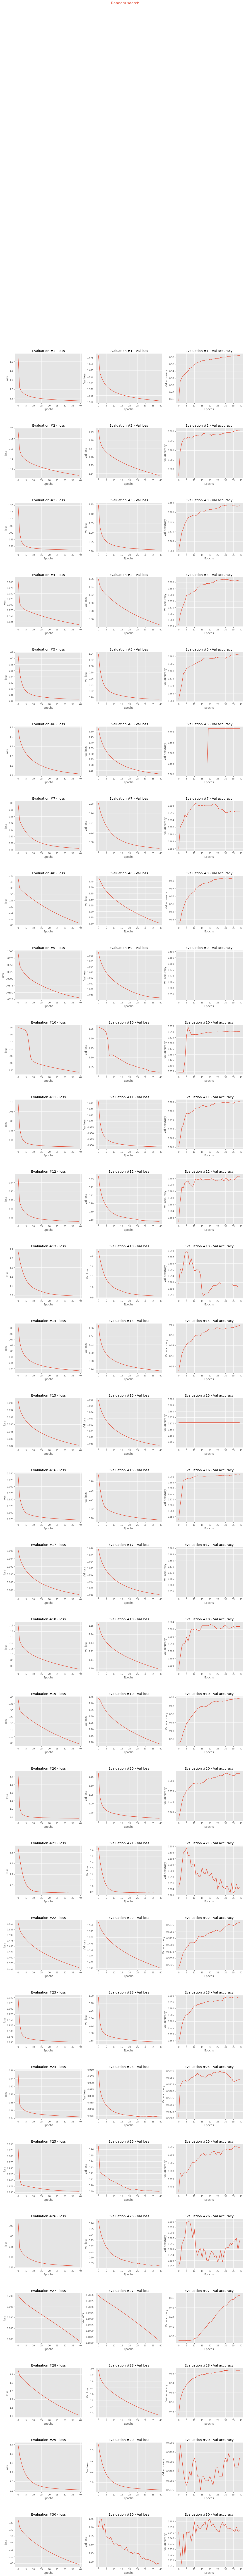

In [32]:
fig, axs = plt.subplots(len(val_loss_list), 3, figsize=(18, 6*evaluations))
fig.suptitle('Random search', y=1 , color='C0', size='16')
fig.subplots_adjust(hspace=0.5)
for i, plot in enumerate(zip(loss_list,val_loss_list,val_accuracy_list)):
    axs[i][0].plot(plot[0])
    axs[i][0].set_title("Evaluation #"+str(i+1)+" - loss")
    axs[i][0].set_xlabel('Epochs')
    axs[i][0].set_ylabel('loss')
    axs[i][1].plot(plot[1])
    axs[i][1].set_title("Evaluation #"+str(i+1)+" - Val loss")
    axs[i][1].set_xlabel('Epochs')
    axs[i][1].set_ylabel('Val loss')
    axs[i][2].plot(plot[2])
    axs[i][2].set_title("Evaluation #"+str(i+1)+" - Val accuracy")
    axs[i][2].set_xlabel('Epochs')
    axs[i][2].set_ylabel('Val accuracy')

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Feature selection</font>

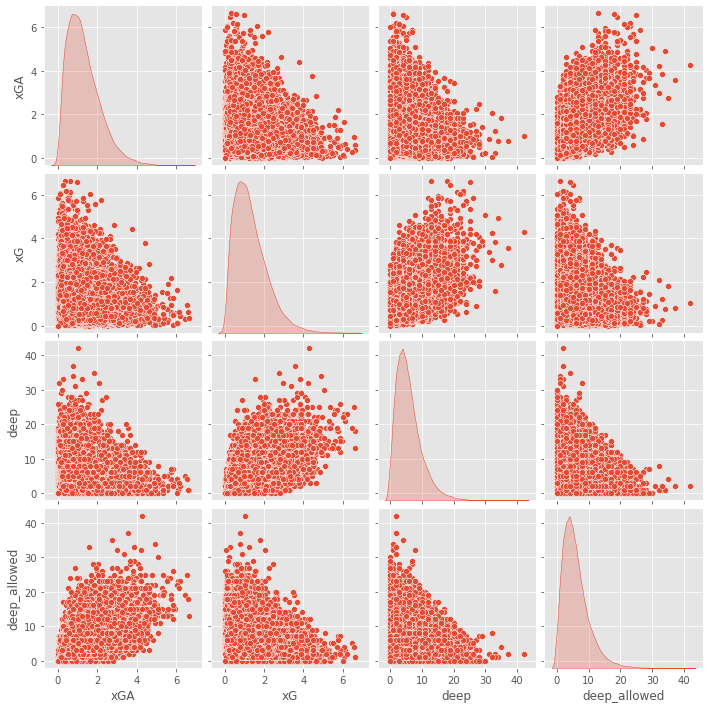

In [33]:
sns.pairplot(all_data[['xGA', 'xG', 'deep', 'deep_allowed']], diag_kind='kde')

In [34]:
all_data.describe().transpose()

count          mean        std       min         25%  \
xG            24580.0  1.309694e+00   0.841109  0.000000    0.681165   
xGA           24580.0  1.309694e+00   0.841109  0.000000    0.681165   
npxG          24580.0  1.193872e+00   0.774719  0.000000    0.621734   
npxGA         24580.0  1.193872e+00   0.774719  0.000000    0.621734   
deep          24580.0  5.806957e+00   4.048151  0.000000    3.000000   
deep_allowed  24580.0  5.806957e+00   4.048151  0.000000    3.000000   
npxGD         24580.0 -1.517636e-18   1.205702 -6.007965   -0.730621   
ppda_coef     24580.0  1.090439e+01   6.163586  0.000000    6.962963   
ppda_att      24580.0  2.396123e+02  83.998463  0.000000  179.000000   
ppda_def      24580.0  2.434959e+01   7.172098  0.000000   19.000000   
oppda_coef    24580.0  1.090439e+01   6.163586  0.000000    6.962963   
oppda_att     24580.0  2.396123e+02  83.998463  0.000000  179.000000   
oppda_def     24580.0  2.434959e+01   7.172098  0.000000   19.000000   
Target        24580.0  1.000000e+00   0.864703  0.000000    0.000000   

                     50%         75%         max  
xG              1.150595    1.769455    6.630490  
xGA             1.150595    1.769455    6.630490  
npxG            1.040425    1.597640    6.610910  
npxGA           1.040425    1.597640    6.610910  
deep            5.000000    8.000000   42.000000  
deep_allowed    5.000000    8.000000   42.000000  
npxGD           0.000000    0.730621    6.007965  
ppda_coef       9.500000   13.095622  152.000000  
ppda_att      231.000000  290.000000  764.000000  
ppda_def       24.000000   29.000000   65.000000  
oppda_coef      9.500000   13.095622  152.000000  
oppda_att     231.000000  290.000000  764.000000  
oppda_def      24.000000   29.000000   65.000000  
Target          1.000000    2.000000    2.000000

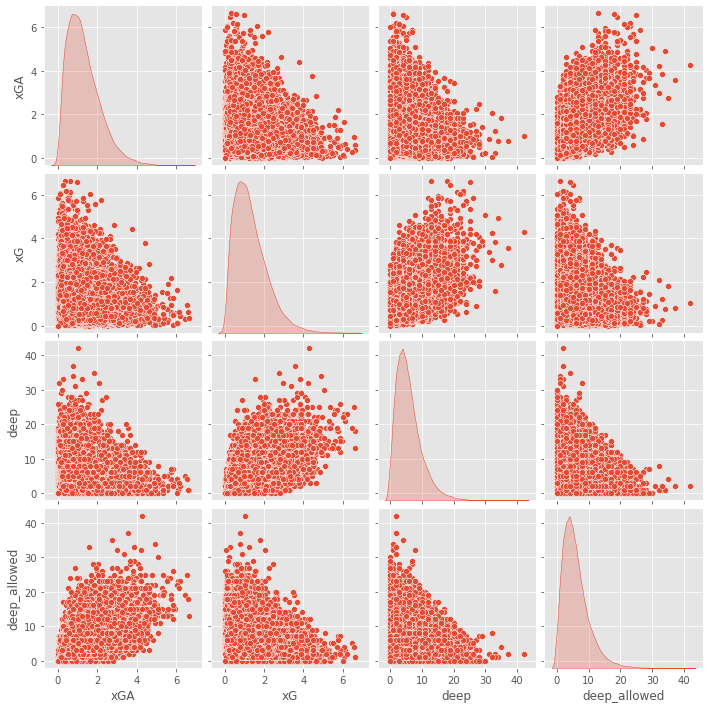

In [35]:
sns.pairplot(all_data[['xGA', 'xG', 'deep', 'deep_allowed']], diag_kind='kde')

<font style='font-weight:750;font-size:14px;text-decoration:underline;'>Manual Features selection   </font>

In [109]:
#in order to run the model using only the manually selected features 
x_train_manual=x_train_arr[:,[1,5,6,7,8,9,10,12]]
x_val_manual=x_val_arr[:,[1,5,6,7,8,9,10,12]]
x_test_manual=x_test_arr[:,[1,5,6,7,8,9,10,12]]
def run_Manual_model(num_units, num_units_list, dropout_list, active_func, optimizer_):
    keras.backend.clear_session()
    model = Sequential()
    for l in range(num_units):
        #to prevent overfitting
        model.add(Dropout(dropout_list[l], input_shape=[x_train_manual.shape[1]]))
        model.add(Dense(num_units_list[l], activation=active_func ,input_shape=[x_train_manual.shape[1]],kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001,l2=0.001)))
    model.add(Dense(3, activation='softmax')) # 3  because we have 3 possible values in the target 

    model.summary()
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer_, metrics=[tf.keras.metrics.CategoricalAccuracy()])
    history = model.fit(x=x_train_manual, y=y_train_arr, batch_size=32, epochs=40, validation_data=(x_val_manual,y_val_arr) , shuffle=False, verbose=2)
    return model, history
 

Running the model with the manually selected features:

In [110]:
#Running the final model with the selected features
final_fsel_manual_run_model, final_fsel_manual_run_history = run_Manual_model(2,[13]*2, [0]*2, 'relu', 'RMSprop')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense (Dense)                (None, 13)                117       
_________________________________________________________________
dropout_1 (Dropout)          (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 42        
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________
Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 2s - loss: 1.0313 - categorical_accuracy: 0.5406 -

In [111]:
prediction_matrix_manual = final_fsel_manual_run_model.predict(x=x_test_manual, batch_size=32, verbose=2)
prediction_result_manual = np.argmax(prediction_matrix_manual, axis=-1)
fsel_manual_error = get_error(y_test, prediction_result_manual)
print('The error using the features selection using "filter"  model is: {}'.format(fsel_manual_error))

3687/3687 - 0s
The error using the features selection using "filter"  model is: 1597.5


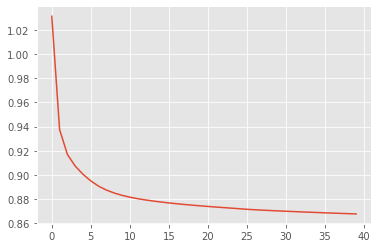

In [112]:
plt.plot(final_fsel_manual_run_history.history['loss'])

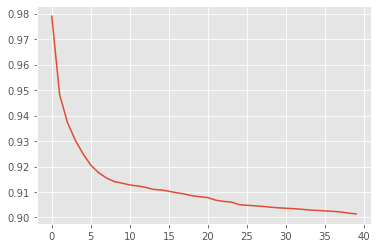

In [113]:
plt.plot(final_fsel_manual_run_history.history['val_loss'])

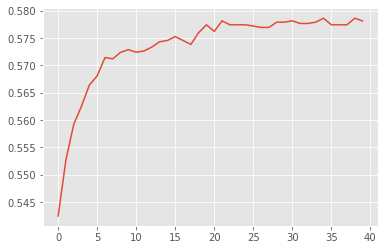

In [114]:
plt.plot(final_fsel_manual_run_history.history['val_categorical_accuracy'])

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Filter Features selection using Chi-Squared statistical test to select 7 of the best features from the dataset  </font>

In [115]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#Performing filter feature selection

# Feature extraction
test_chi2 = SelectKBest(score_func=chi2)
fit_chi2 = test_chi2.fit(x_train_arr, y_train_arr)
print(y_train_arr.shape)
    
# Summarize scores
np.set_printoptions(precision=0)
print(fit_chi2.scores_)
print(set(data))

(16714, 3)
[299. 308. 258. 268.  53.  52. 109.   5.  10.   1.   6.  10.   2.]
{'npxGD', 'oppda_att', 'npxGA', 'oppda_coef', 'npxG', 'deep', 'xG', 'xGA', 'ppda_def', 'oppda_def', 'deep_allowed', 'ppda_coef', 'ppda_att'}


In [116]:
#in order to run the model using only the selected features 
x_train_filter=x_train_arr[:,[0,1,2,3,4,5,6]]
x_val_filter=x_val_arr[:,[0,1,2,3,4,5,6]]
x_test_filter=x_test_arr[:,[0,1,2,3,4,5,6]]
def run_filter_model(num_units, num_units_list, dropout_list, active_func, optimizer_):
    keras.backend.clear_session()
    model = Sequential()
    for l in range(num_units):
        #to prevent overfitting
        model.add(Dropout(dropout_list[l], input_shape=[x_train_filter.shape[1]]))
        model.add(Dense(num_units_list[l], activation=active_func ,input_shape=[x_train_filter.shape[1]],kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001,l2=0.001)))
    model.add(Dense(3, activation='softmax')) # 3  because we have 3 possible values in the target 

    model.summary()
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer_, metrics=[tf.keras.metrics.CategoricalAccuracy()])
    history = model.fit(x=x_train_filter, y=y_train_arr, batch_size=32, epochs=40, validation_data=(x_val_filter,y_val_arr) , shuffle=False, verbose=2)
    return model, history
 

You can see the scores for each attribute and the 7 attributes chosen (those with the highest scores) 

{'npxGD', 'oppda_att', 'npxGA', 'oppda_coef', 'oppda_def', 'deep_allowed', 'ppda_coef'}


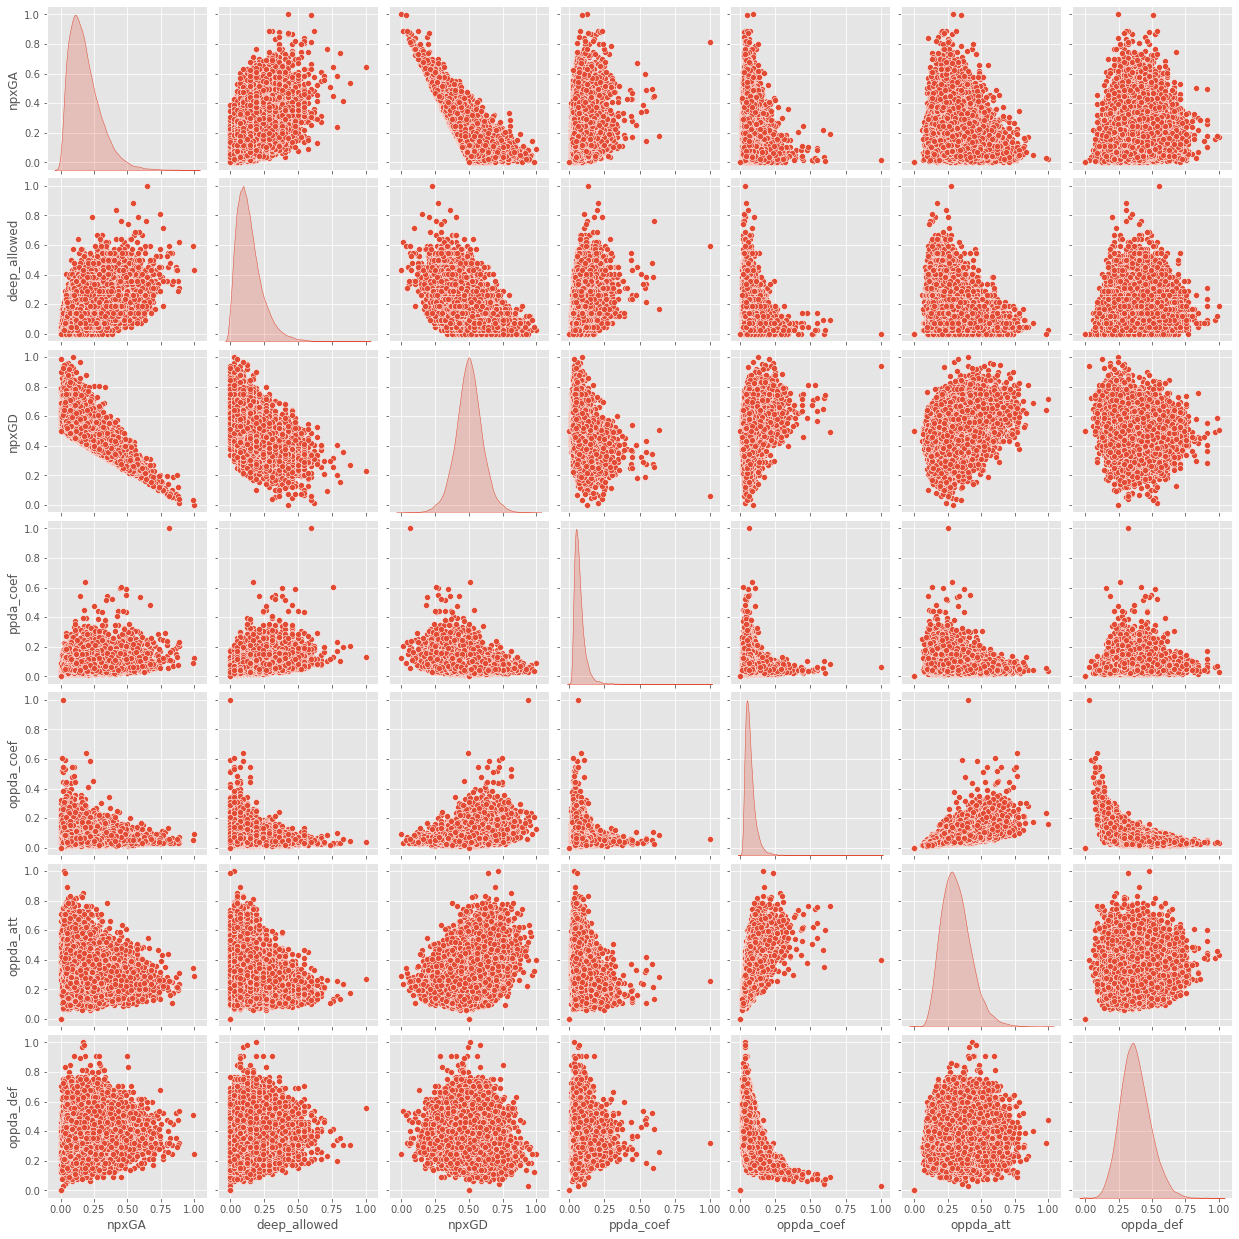

In [117]:
#Keeping only selected featuers from the filter process
fsel_filter_data=data.copy()
fsel_filter_data=fsel_filter_data.drop(['xGA', 'ppda_att', 'npxG', 'xG', 'ppda_def', 'deep'], axis=1)
print(set(fsel_filter_data))
sns.pairplot(fsel_filter_data, diag_kind='kde')

Running the model with the selected features using the filter method:

In [118]:
#Running the final model with the selected features
final_fsel_filter_run_model, final_fsel_filter_run_history = run_filter_model(2,[13]*2, [0]*2, 'relu', 'RMSprop')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 7)                 0         
_________________________________________________________________
dense (Dense)                (None, 13)                104       
_________________________________________________________________
dropout_1 (Dropout)          (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 42        
Total params: 328
Trainable params: 328
Non-trainable params: 0
_________________________________________________________________
Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 1s - loss: 1.0183 - categorical_accuracy: 0.5577 -

In [119]:
prediction_matrix_filter = final_fsel_filter_run_model.predict(x=x_test_filter, batch_size=32, verbose=2)
prediction_result_filter = np.argmax(prediction_matrix_filter, axis=-1)
fsel_filter_error = get_error(y_test, prediction_result_filter)
print('The error using the features selection using "filter"  model is: {}'.format(fsel_filter_error))

3687/3687 - 0s
The error using the features selection using "filter"  model is: 1421.5


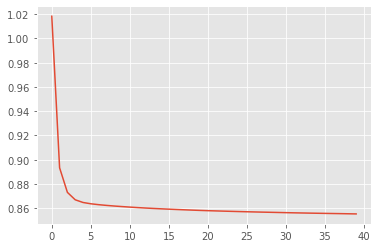

In [120]:
plt.plot(final_fsel_filter_run_history.history['loss'])

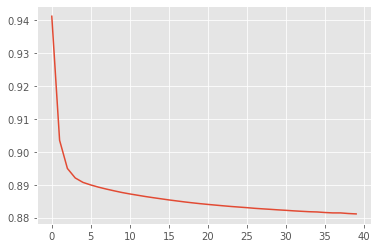

In [121]:
plt.plot(final_fsel_filter_run_history.history['val_loss'])

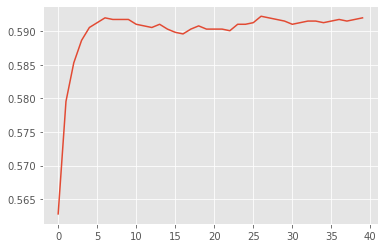

In [122]:
plt.plot(final_fsel_filter_run_history.history['val_categorical_accuracy'])

Performing Wrapper with RFE:

In [123]:
#in order to run the model using only the selected features from the Wrapper (RFE) method:
x_train_wrap=x_train_arr[:,[0,1,6,7,8,10]]
x_val_wrap=x_val_arr[:,[0,1,6,7,8,10]]
x_test_wrap=x_test_arr[:,[0,1,6,7,8,10]]

def run_wrap_model(num_units, num_units_list, dropout_list, active_func, optimizer_):
    keras.backend.clear_session()
    model = Sequential()
    for l in range(num_units):
        #to prevent overfitting
        model.add(Dropout(dropout_list[l], input_shape=[x_train_wrap.shape[1]]))
        model.add(Dense(num_units_list[l], activation=active_func ,input_shape=[x_train_wrap.shape[1]],kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001,l2=0.001)))
    model.add(Dense(3, activation='softmax')) # 3  because we have 3 possible values in the target 

    model.summary()
    
    model.compile(loss="categorical_crossentropy", optimizer=optimizer_, metrics=[tf.keras.metrics.CategoricalAccuracy()])
    history = model.fit(x=x_train_wrap, y=y_train_arr, batch_size=32, epochs=40, validation_data=(x_val_wrap,y_val_arr) , shuffle=False, verbose=2)
    return model, history

In [124]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Feature extraction
model_wrap = LogisticRegression()
rfe = RFE(model_wrap)
# Creating 1-D y Array
y_RFE=np.zeros([len(y_train_arr)])
for i in range(len(y_train_arr)):
    if(y_train_arr[i,1]==1):
        y_RFE[i]=1
    elif(y_train_arr[i,2]==1):
        y_RFE[i]=2
    else:
        y_RFE[i]=3 
#Trainig the Wrap Model and prinint results
fit_wrap = rfe.fit(x_train_arr, y_RFE)
print("Num Features: %s" % (fit_wrap.n_features_))
print("Selected Features: %s" % (fit_wrap.support_))
print("Feature Ranking: %s" % (fit_wrap.ranking_))
print(set(data))

C:\Users\cwoamh\Anaconda3\envs\tf\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Num Features: 6
Selected Features: [ True  True False False False  True  True  True False False  True False
 False]
Feature Ranking: [1 1 3 2 4 1 1 1 5 7 1 6 8]
{'npxGD', 'oppda_att', 'npxGA', 'oppda_coef', 'npxG', 'deep', 'xG', 'xGA', 'ppda_def', 'oppda_def', 'deep_allowed', 'ppda_coef', 'ppda_att'}


{'npxGD', 'oppda_att', 'deep', 'xG', 'xGA', 'deep_allowed'}


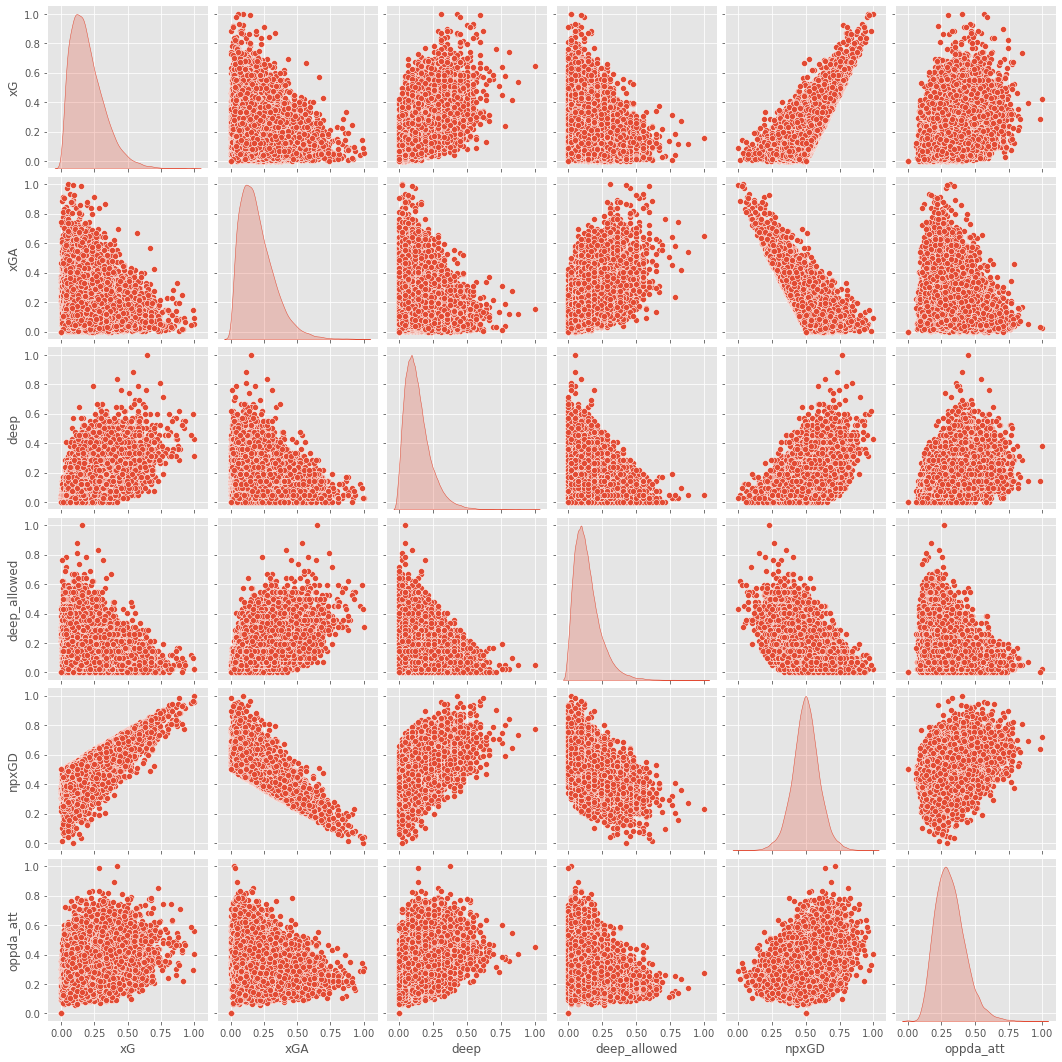

In [125]:
#Keeping only selected featuers from the Wrapper process
fsel_wrap_data=data.copy()
fsel_wrap_data=fsel_wrap_data.drop([ 'npxGA', 'oppda_coef', 'npxG','ppda_def', 'oppda_def','ppda_coef', 'ppda_att'], axis=1)
print(set(fsel_wrap_data))
sns.pairplot(fsel_wrap_data, diag_kind='kde')

In [126]:
#Running the final model with the selected features
final_fsel_wrap_run_model, final_fsel_wrap_run_history = run_wrap_model(2,[13]*2, [0]*2, 'relu', 'RMSprop')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 13)                91        
_________________________________________________________________
dropout_1 (Dropout)          (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 42        
Total params: 315
Trainable params: 315
Non-trainable params: 0
_________________________________________________________________
Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 1s - loss: 1.0171 - categorical_accuracy: 0.5276 -

In [127]:
prediction_matrix_wrap = final_fsel_wrap_run_model.predict(x=x_test_wrap, batch_size=32, verbose=2)
prediction_result_wrap = np.argmax(prediction_matrix_wrap, axis=-1)
fsel_wrap_error = get_error(y_test, prediction_result_wrap)
print('The error of the features selected wrapper model is: {}'.format(fsel_wrap_error))

3687/3687 - 0s
The error of the features selected wrapper model is: 1417.5


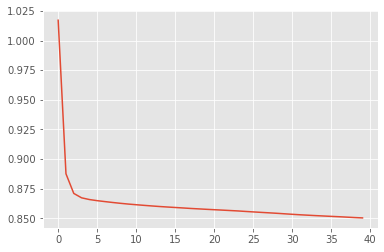

In [128]:
plt.plot(final_fsel_wrap_run_history.history['loss'])

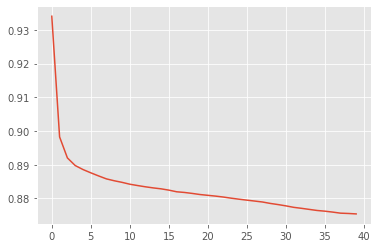

In [129]:
plt.plot(final_fsel_wrap_run_history.history['val_loss'])

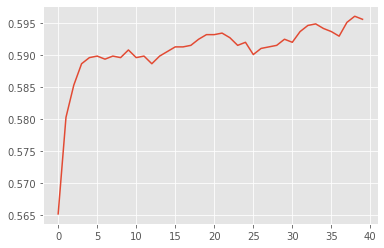

In [130]:
plt.plot(final_fsel_wrap_run_history.history['val_categorical_accuracy'])

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Final Model</font>

In [131]:
final_run_model, final_run_history= run_model(2,[13]*2, [0]*2, 'relu', 'RMSprop')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 13)                0         
_________________________________________________________________
dense (Dense)                (None, 13)                182       
_________________________________________________________________
dropout_1 (Dropout)          (None, 13)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 13)                182       
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 42        
Total params: 406
Trainable params: 406
Non-trainable params: 0
_________________________________________________________________
Train on 16714 samples, validate on 4179 samples
Epoch 1/40
16714/16714 - 1s - loss: 0.9614 - categorical_accuracy: 0.5747 -

In [132]:
final_prediction_matrix = final_run_model.predict(x=x_test, batch_size=32, verbose=2)
final_prediction_result = np.argmax(final_prediction_matrix, axis=-1)
final_model_error = get_error(y_test, final_prediction_result)
print('The error of the final model is: {}'.format(final_model_error))

3687/3687 - 0s
The error of the final model is: 1389.0


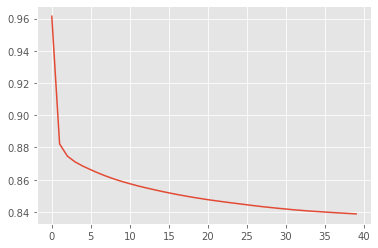

In [133]:
plt.plot(final_run_history.history['loss'])

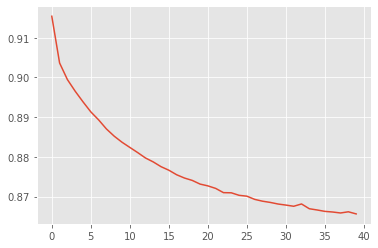

In [134]:
plt.plot(final_run_history.history['val_loss'])

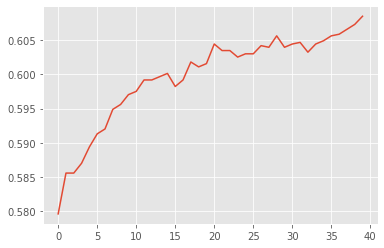

In [135]:
plt.plot(final_run_history.history['val_categorical_accuracy'])

<font style='font-weight:750;font-size:16px;text-decoration:underline;'>Bonus - Model comparison</font>

In [136]:
# AIC
results.sort_values('AIC', ascending = True, inplace = True)
display(results)

Evaluation # of layers # of units per layer Activation function Optimizer  \
24         25           6                    6                relu   RMSprop   
22         23           1                   23                tanh    Adamax   
23         24           1                   39                selu   RMSprop   
15         16           9                    5                tanh    Adamax   
11         12           2                   26              linear   RMSprop   
6           7           4                   22              linear    Adamax   
4           5           6                   21              linear   RMSprop   
3           4           4                   27                tanh       SGD   
13         14           2                   46              linear   Adagrad   
9          10           7                   19                relu       SGD   
26         27          12                    8              linear  Adadelta   
1           2           6                   36                selu   Adagrad   
16         17          14                    1              linear      Ftrl   
14         15          11                    4                tanh      Ftrl   
17         18           5                   41                selu   Adagrad   
29         30          16                   21                selu       SGD   
10         11           6                   39              linear   RMSprop   
25         26          10                   32                relu      Adam   
2           3          11                   30              linear   RMSprop   
28         29          16                   26                tanh    Adamax   
12         13          14                   28                tanh    Adamax   
0           1          16                   27                selu  Adadelta   
18         19           8                   39                tanh       SGD   
7           8           8                   44              linear       SGD   
21         22          12                   40              linear   Adagrad   
5           6          14                   32                relu   Adagrad   
20         21          12                   48                selu      Adam   
27         28          12                   47                tanh       SGD   
19         20          15                   43              linear   RMSprop   
8           9          15                   48              linear      Ftrl   

    Val loss Val loss Delta      MSE # of params     BIC     AIC  
24  0.889928      0.0753264     6283         315  149237  146804  
22  0.875293       0.121595     6289         394  150021  146978  
23  0.874499      0.0340043     6372         666  152885  147741  
15  0.896166      0.0981645   6798.5         328  150681  148148  
11   0.87758      0.0560462     6367        1147  157549  148690  
6   0.886914      0.0940219     6256        1895  164529  149892  
4    0.89351       0.145261     6533        2670  172789  152166  
3   0.946027       0.112389   6603.5        2730  173552  152466  
13    0.9568       0.109061   6571.5        2947  175581  152818  
9    1.02245       0.236421   7607.5        2606  174712  154583  
26   1.18589      0.0188996  11416.5         931  165209  158018  
1    1.13766      0.0544287   6150.5        7275  216560  160368  
16   1.08902     0.00684016  14608.5          46  160724  160369  
14   1.08873      0.0071905  14608.5         271  162912  160819  
17   1.09902      0.0530666   6121.5        7588  219524  160915  
29   1.18683       0.216758   7582.5        7290  220204  163896  
10  0.893153       0.188377   6932.5        8466  230142  164750  
25   0.88559      0.0785837     5965       10051  243042  165408  
2   0.906425        0.24163   6974.5        9813  243341  167545  
28  0.930457       0.420883   6356.5       10975  253089  168318  
12  0.912852       0.430889   6814.5       11035  254836  169601  
0    1.50397       0.178898     6440       11802

In [137]:
# BIC
results.sort_values('BIC', ascending = True, inplace = True)
display(results)

Evaluation # of layers # of units per layer Activation function Optimizer  \
24         25           6                    6                relu   RMSprop   
22         23           1                   23                tanh    Adamax   
15         16           9                    5                tanh    Adamax   
23         24           1                   39                selu   RMSprop   
11         12           2                   26              linear   RMSprop   
16         17          14                    1              linear      Ftrl   
14         15          11                    4                tanh      Ftrl   
6           7           4                   22              linear    Adamax   
26         27          12                    8              linear  Adadelta   
4           5           6                   21              linear   RMSprop   
3           4           4                   27                tanh       SGD   
9          10           7                   19                relu       SGD   
13         14           2                   46              linear   Adagrad   
1           2           6                   36                selu   Adagrad   
17         18           5                   41                selu   Adagrad   
29         30          16                   21                selu       SGD   
10         11           6                   39              linear   RMSprop   
25         26          10                   32                relu      Adam   
2           3          11                   30              linear   RMSprop   
28         29          16                   26                tanh    Adamax   
12         13          14                   28                tanh    Adamax   
18         19           8                   39                tanh       SGD   
0           1          16                   27                selu  Adadelta   
7           8           8                   44              linear       SGD   
5           6          14                   32                relu   Adagrad   
21         22          12                   40              linear   Adagrad   
27         28          12                   47                tanh       SGD   
20         21          12                   48                selu      Adam   
19         20          15                   43              linear   RMSprop   
8           9          15                   48              linear      Ftrl   

    Val loss Val loss Delta      MSE # of params     BIC     AIC  
24  0.889928      0.0753264     6283         315  149237  146804  
22  0.875293       0.121595     6289         394  150021  146978  
15  0.896166      0.0981645   6798.5         328  150681  148148  
23  0.874499      0.0340043     6372         666  152885  147741  
11   0.87758      0.0560462     6367        1147  157549  148690  
16   1.08902     0.00684016  14608.5          46  160724  160369  
14   1.08873      0.0071905  14608.5         271  162912  160819  
6   0.886914      0.0940219     6256        1895  164529  149892  
26   1.18589      0.0188996  11416.5         931  165209  158018  
4    0.89351       0.145261     6533        2670  172789  152166  
3   0.946027       0.112389   6603.5        2730  173552  152466  
9    1.02245       0.236421   7607.5        2606  174712  154583  
13    0.9568       0.109061   6571.5        2947  175581  152818  
1    1.13766      0.0544287   6150.5        7275  216560  160368  
17   1.09902      0.0530666   6121.5        7588  219524  160915  
29   1.18683       0.216758   7582.5        7290  220204  163896  
10  0.893153       0.188377   6932.5        8466  230142  164750  
25   0.88559      0.0785837     5965       10051  243042  165408  
2   0.906425        0.24163   6974.5        9813  243341  167545  
28  0.930457       0.420883   6356.5       10975  253089  168318  
12  0.912852       0.430889   6814.5       11035  254836  169601  
18   1.08829       0.348146     6884       11586